<h1>training_demo</h1>

<p>Overview - extract some data and examine how the physiometrics which are measured affect the prediction accuracy</p>
<ol>
    <li><a href='#mortality'>Mortality Results</a></li>
    <li><a href='#los'>Length of Stay Results</a></li>
    <li><a href='#sensitive'>Sensitive Group Results</a></li>
</ol>

In [1]:
%matplotlib inline
# import the dependencies
import pandas as pd
import numpy as np
# import h5py
import os
# import pandas.io.sql as psql

# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import label_binarize


import matplotlib.pyplot as plt
import glob
from IPython.display import display

import copy
# from tqdm import tqdm
# from utils import AUC_GH



<h2> How well does the data persist from year to year?</h2>

Read the years datafrom the server.

In [2]:
# text_files=glob.glob('HIDENIC_overtime_analysis/result_*.txt')

dir_path = "../../../output/HIDENIC_overtime_analysis/with_month_intervals/"

text_files  = [fname for fname in os.listdir(dir_path) if fname.startswith('result_') and fname.endswith(".txt")]

text_files

['result_first-years-style_2010_1CLASS_SVM_NOVEL_pca_Simple_itemid_seed-0_test-size-02_target=los_3.txt',
 'result_first-years-style_2010_1CLASS_SVM_NOVEL_pca_Simple_itemid_seed-0_test-size-02_target=mort_icu.txt',
 'result_first-years-style_2010_1CLASS_SVM_NOVEL_raw_Simple_itemid_seed-0_test-size-02_target=los_3.txt',
 'result_first-years-style_2010_1CLASS_SVM_NOVEL_raw_Simple_itemid_seed-0_test-size-02_target=mort_icu.txt',
 'result_first-years-style_2010_1CLASS_SVM_pca_Simple_itemid_seed-0_test-size-02_target=los_3.txt',
 'result_first-years-style_2010_1CLASS_SVM_pca_Simple_itemid_seed-0_test-size-02_target=mort_icu.txt',
 'result_first-years-style_2010_1CLASS_SVM_raw_Simple_itemid_seed-0_test-size-02_target=los_3.txt',
 'result_first-years-style_2010_1CLASS_SVM_raw_Simple_itemid_seed-0_test-size-02_target=mort_icu.txt',
 'result_first-years-style_2010_IFOREST_pca_Simple_itemid_seed-0_test-size-02_target=los_3.txt',
 'result_first-years-style_2010_IFOREST_pca_Simple_itemid_seed-0_te

In [3]:
def my_calibration_curve(y_true, y_prob, n_bins, strategy):

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Only binary classification is supported. "
                         "Provided labels %s." % labels)
    y_true = label_binarize(y_true, labels)[:, 0]

    if strategy == 'quantile':  ## equal-frequency bins 
        # Determine bin edges by distribution of data 
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
        bins[-1] = bins[-1] + 1e-8
    elif strategy == 'uniform': ## equal-width bins
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    else:
        raise ValueError("Invalid entry to 'strategy' input. Strategy "
                         "must be either 'quantile' or 'uniform'.")

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = (bin_true[nonzero] / bin_total[nonzero])
    prob_pred = (bin_sums[nonzero] / bin_total[nonzero])
    
    abs_error = np.abs(prob_pred - prob_true)

    expected_error = np.average(abs_error, weights=(bin_total / y_true.size)[nonzero])
    max_error = np.max(abs_error)

    return prob_true, prob_pred, expected_error, max_error

In [26]:
# list of text files
# text_files=glob.glob('result_*.txt')

#make a dataframe of all the data
#column headings: modeltype, level, representation, train_type, measurement
#index=random_seed

models = ['rf', 'iforest', 'lr', 'rbf-svm', '1class_svm', '1class_svm_novel', 'knn', 'mlp', 'lstm', 'grud']
targets = ['mort_icu', 'los_3']
reps = ['raw', 'pca', 'umap', 'autoencoder', 'nlp']
# train_types = ['first-years', 'Rolling', 'Rolling_limited']
measures = ['AUC', 'APR', 'Acc', 'F1', 'date_trained', 'ECE', 'MCE' 'O_E']
year_range = np.arange(2011, 2015)
month_step = 2
month_intervals = np.arange(month_step, 13, month_step)

columns=[]
for target in targets:
    for model in models:
        for representation in reps:
            for measurement in measures:
                columns.append((target,model, representation, measurement))
                    
index=[(y, m) for y in year_range for m in month_intervals]
ind=pd.MultiIndex.from_tuples(index, names=('year', 'month_interval'))
cols=pd.MultiIndex.from_tuples(columns, names=('target', 'model', 'representation', 'measurement'))
df=pd.DataFrame( index=ind, columns=cols) # 4 columns, 2 indices

# print(cols)

# cols=pd.MultiIndex.from_tuples(set([(item[0], item[1], item[2], item[4]) for item in columns]), names=('target', 'model', 'representation', 'measurement'))
# empty_data=np.empty((5,len(set([(item[0], item[1], item[2], item[4]) for item in columns]))))
# empty_data[:] = np.nan
# no_years_df=pd.DataFrame(data=empty_data, columns=cols)


for target in targets:
    print(target)
    for modeltype in models:
        for representation in reps:
            for text_file in sorted(text_files):
                if target not in text_file:
                    continue
                if (modeltype.upper() in text_file) and (representation in text_file):
                    # train_type=text_file.split("result_")[-1].split('-style')[0]
                    # print(train_type)

                    # assert(train_type in train_types)
                    seed=text_file.split("seed-")[-1].split('_test-')[0]
                    if seed ==5:
                        continue
                    # if train_type=='no_years':
                    #     seed=text_file.split("seed-")[-1].split('_target')[0]

                    with open(os.path.join(dir_path, text_file), 'rb') as f:
                        all_lines=f.readlines()
                    try:
                        df.loc[:, (target, modeltype, representation, 'date_trained')]=os.path.getmtime(os.path.join(dir_path, text_file))
                    except:
                        print(os.path.getmtime(os.path.join(dir_path, text_file)), int(seed))
                     
                    ## add calibration measures
                    for year in year_range:
                        for month in month_intervals:
                            ## collect lines with the same year and months
                            lines = [line.decode() for line in all_lines if (str(year) in line.decode().split(",")[1]) and (line.decode().split("<")[1].split(">")[0] == ','.join([str(m) for m in np.arange(month-month_step+1, month+1, 1)]))]
                            for line in lines:
                                if ('label' in line):
                                    y_true= [float(i) for i in line.split('<')[2].split('>')[0].split(',')]
                                if ('y_pred_prob' in line):
                                    y_pred= [float(i) for i in line.split('<')[2].split('>')[0].split(',')]
                            
                            if (modeltype in ['1class_svm', '1class_svm_novel', 'iforest', 'rbf-svm']):
                                y_pred = (y_pred - np.min(y_pred))/ (np.max(y_pred) - np.min(y_pred))

                            try:
                                _,_,ECE,MCE = my_calibration_curve(y_true, y_pred, 10, 'quantile')
                            except Exception as err:
                                print("couldn't compute ECE,MCE for {}_{}_{}_{}_{}: {}".format(year, month, target, modeltype, representation, err))
                                ECE = MCE = np.nan
                                
                            O_E = np.mean(y_true)/np.mean(y_pred)

                            df.loc[(int(year), int(month)), (target, modeltype, representation, 'ECE')]=ECE
                            df.loc[(int(year), int(month)), (target, modeltype, representation, 'MCE')]=MCE
                            df.loc[(int(year), int(month)), (target, modeltype, representation, 'O_E')]=O_E

                    
                    for measurement in ['AUC', 'APR', 'Acc', 'F1']:
                        lines=[line.decode() for line in all_lines if measurement in line.decode()]
                        for line in lines:
                            for year in year_range:
                                if (str(year) in line.split(",")[1]):
                                    for month in month_intervals:
                                        # print(month)
                                        if (line.split("<")[1].split(">")[0] == ','.join([str(m) for m in np.arange(month-month_step+1, month+1, 1)])):
                                            value=float(line.split(",")[-1])
                                            # print(year, month, target, modeltype, representation, measurement, value)
                                            df.loc[(int(year), int(month)), 
                                                   (target, modeltype, representation, measurement)]=value


df=df.apply(pd.to_numeric, errors='coerce')

mort_icu
los_3


C:\Users\mot16\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


couldn't compute ECE,MCE for 2011_2_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2011_4_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2011_6_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2011_10_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2011_12_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2012_2_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2012_4_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2012_6_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2012_8_los_3_1class_svm_raw: 'list' argument must have no negative elements
couldn't compute ECE,MCE for 2012_10_los_3_1class_svm

In [5]:
# mask = df.notna().any(axis=0)
# tmp = df.loc[0 , mask]

# idx=pd.IndexSlice

# tmp.loc[:, idx[:,:,:,:, 'date_trained']] = tmp.loc[:, idx[:,:,:,:, 'date_trained']].apply(lambda x: pd.to_datetime(x, unit='s'))

# tmp

KeyError: 0

In [27]:
df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')
idx = pd.IndexSlice
averaged_df=df.groupby(['year', 'month_interval']).mean().loc[:, idx[:,:,:, ['AUC', 'APR', 'ECE', 'MCE','O_E']]]
# ste_df=df.groupby('year').std().loc[:, (slice(None), slice(None), slice(None), slice(None), metric)]/np.sqrt(5)
# averaged_static_df=no_years_df.mean()

In [28]:
# averaged_df.columns = averaged_df.columns.droplevel(-1)
# ste_df.columns = ste_df.columns.droplevel(-1)

## mortality and los_3 rates

In [121]:
d = pd.read_csv("E:/Data/HIDENIC_EXTRACT_OUTPUT_DIR/POP_SIZE_0/ITEMID_REP/static_data.csv")

In [123]:
d.intime = pd.to_datetime(d.intime)
d['los_icu']*=24
d['los_3']=np.zeros((len(d),1)).ravel()
d.loc[d['los_icu']>=3*24, 'los_3']=1

In [131]:
mort_icu_2010 = d.loc[(d.intime.dt.year == 2010) & (d.los_icu > 36), 'mort_icu']
mort_icu_2010.mean()

0.06511881008525304

In [132]:
los3_2010 = d.loc[(d.intime.dt.year == 2010) & (d.los_icu > 36), 'los_3']
los3_2010.mean()

0.4597315436241611

In [85]:
index=[(y, m) for y in year_range for m in month_intervals]
ind=pd.MultiIndex.from_tuples(index, names=('year', 'month_interval'))
dat=pd.DataFrame( index=ind, columns=['mort_icu', 'los_3']) 

for target in targets:
    text_file = [f for f in text_files if (target in f)][0]
    with open(os.path.join(dir_path, text_file), 'rb') as f:
        all_lines=f.readlines()

    for year in year_range:
        for month in month_intervals:
            ## collect lines with the same year and months
            lines = [line.decode() for line in all_lines if (str(year) in line.decode().split(",")[1]) and (line.decode().split("<")[1].split(">")[0] == ','.join([str(m) for m in np.arange(month-month_step+1, month+1, 1)]))]
            for line in lines:
                if ('label' in line):
                    y_true= [float(i) for i in line.split('<')[2].split('>')[0].split(',')]
            dat.loc[(year, month), target] = np.mean(y_true)


In [86]:
dat

mort_icu     los_3
year month_interval                     
2011 2               0.0705275  0.487385
     4               0.0557554  0.440647
     6               0.0627542  0.455549
     8               0.0556818  0.450568
     10              0.0731272  0.448276
     12              0.0773994  0.425387
2012 2               0.0668693  0.455927
     4               0.0581948  0.456057
     6                   0.065      0.43
     8               0.0662651  0.420482
     10              0.0606401  0.428411
     12              0.0716454  0.452945
2013 2               0.0697236  0.440327
     4               0.0639752  0.413043
     6               0.0613978  0.421293
     8               0.0675159  0.415287
     10              0.0624598  0.397296
     12                 0.0625  0.443614
2014 2               0.0652617   0.42692
     4               0.0659196  0.427818
     6               0.0600858  0.414163
     8               0.0585496   0.42515
     10              0.0516678  0.395683
     12                   0.08    0.4175

Text(0.5, 0, 'year, month_interval')

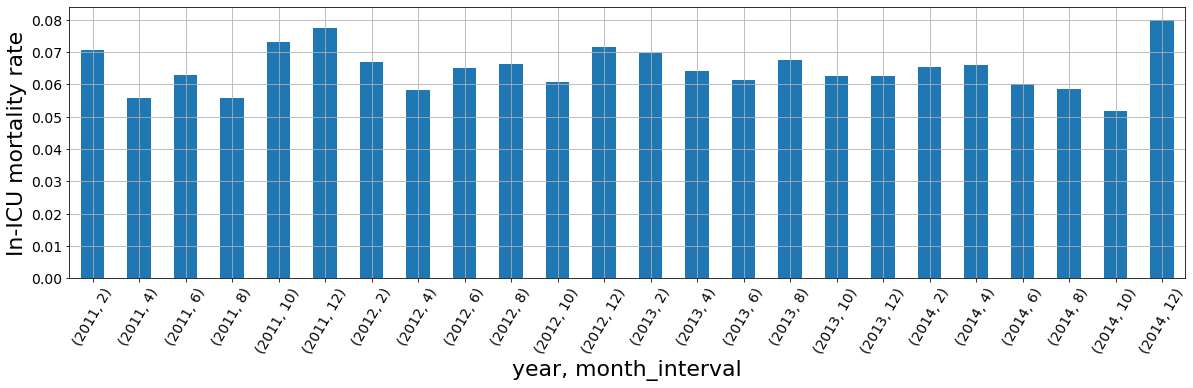

In [110]:
ax = dat['mort_icu'].plot(kind='bar', figsize=(20, 5), rot=60, fontsize = 14, grid=True)
ax.set_ylabel('In-ICU mortality rate', fontsize= 22)
ax.set_xlabel('year, month_interval', fontsize= 22)

Text(0.5, 0, 'year, month_interval')

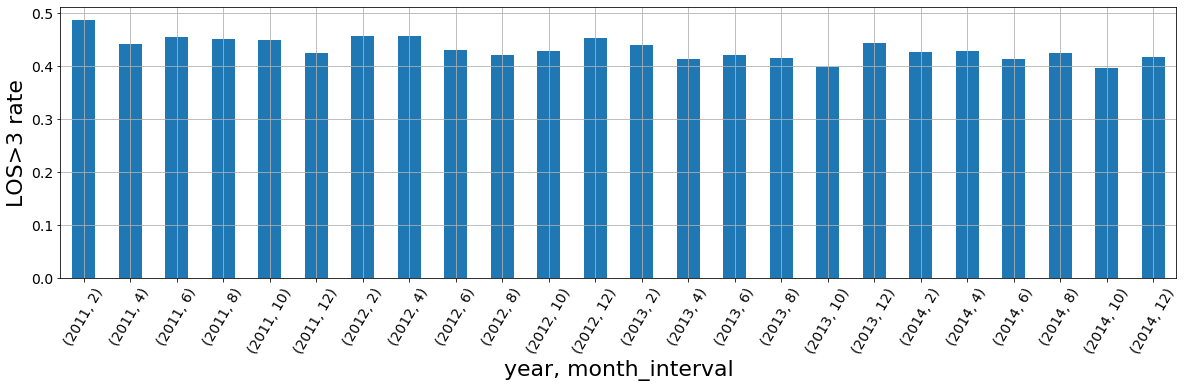

In [111]:
ax = dat['los_3'].plot(kind='bar', figsize=(20, 5), rot=60, fontsize = 14, grid=True)
ax.set_ylabel('LOS>3 rate', fontsize= 22)
ax.set_xlabel('year, month_interval', fontsize= 22)

<h2>Plots for Mortality</h2>
<a id=mortality></a>

This block of code produces subplots with shared x axes and y axes in the range of 0.5-1 for all AUCs on the task of mortality

In [39]:
MODEL_TYPES

{'1class_svm', '1class_svm_novel', 'iforest', 'lr', 'rbf-svm', 'rf'}

In [40]:
# TRAIN_STYLES    = set(df.columns.get_level_values('train_type')) # ['first-years', 'Rolling_limited', 'Rolling']
MEASURES = ['O_E', 'ECE', 'MCE', 'AUC', 'APR'] # set(averaged_df.columns.get_level_values('measurement'))
REPRESENTATIONS = ['raw', 'pca'] #set(averaged_df.columns.get_level_values('representation'))
MODEL_TYPES     = ['rf', 'lr', 'rbf-svm', 'iforest', '1class_svm', '1class_svm_novel']#set(averaged_df.columns.get_level_values('model'))

NAMES = {
    'first-years': '2010',
    'Rolling': 'Full History',
    'Rolling_limited': 'Prior Year',
    'itemid': 'Raw',
    'raw': 'Raw',
    'pca': 'PCA',
    'umap': 'UMAP',
    'nlp': 'CUI Code Spanning',
    'Level2': 'Clinical Aggregations',
    'rf': 'Random Forest',
    'lr': 'Logistic Regression',
    'lstm': 'LSTM',
    'grud': 'GRU-D',
    'rbf-svm': 'SVM',
    'iforest': 'Isolation Forest', 
    '1class_svm': 'One-class SVM (Outlier detection)', 
    '1class_svm_novel': "One-class SVM (Novelty detection)"
}

In [112]:
sorted(averaged_df.index.get_level_values('year').unique().tolist())

[2011, 2012, 2013, 2014]

<Figure size 1200x800 with 0 Axes>

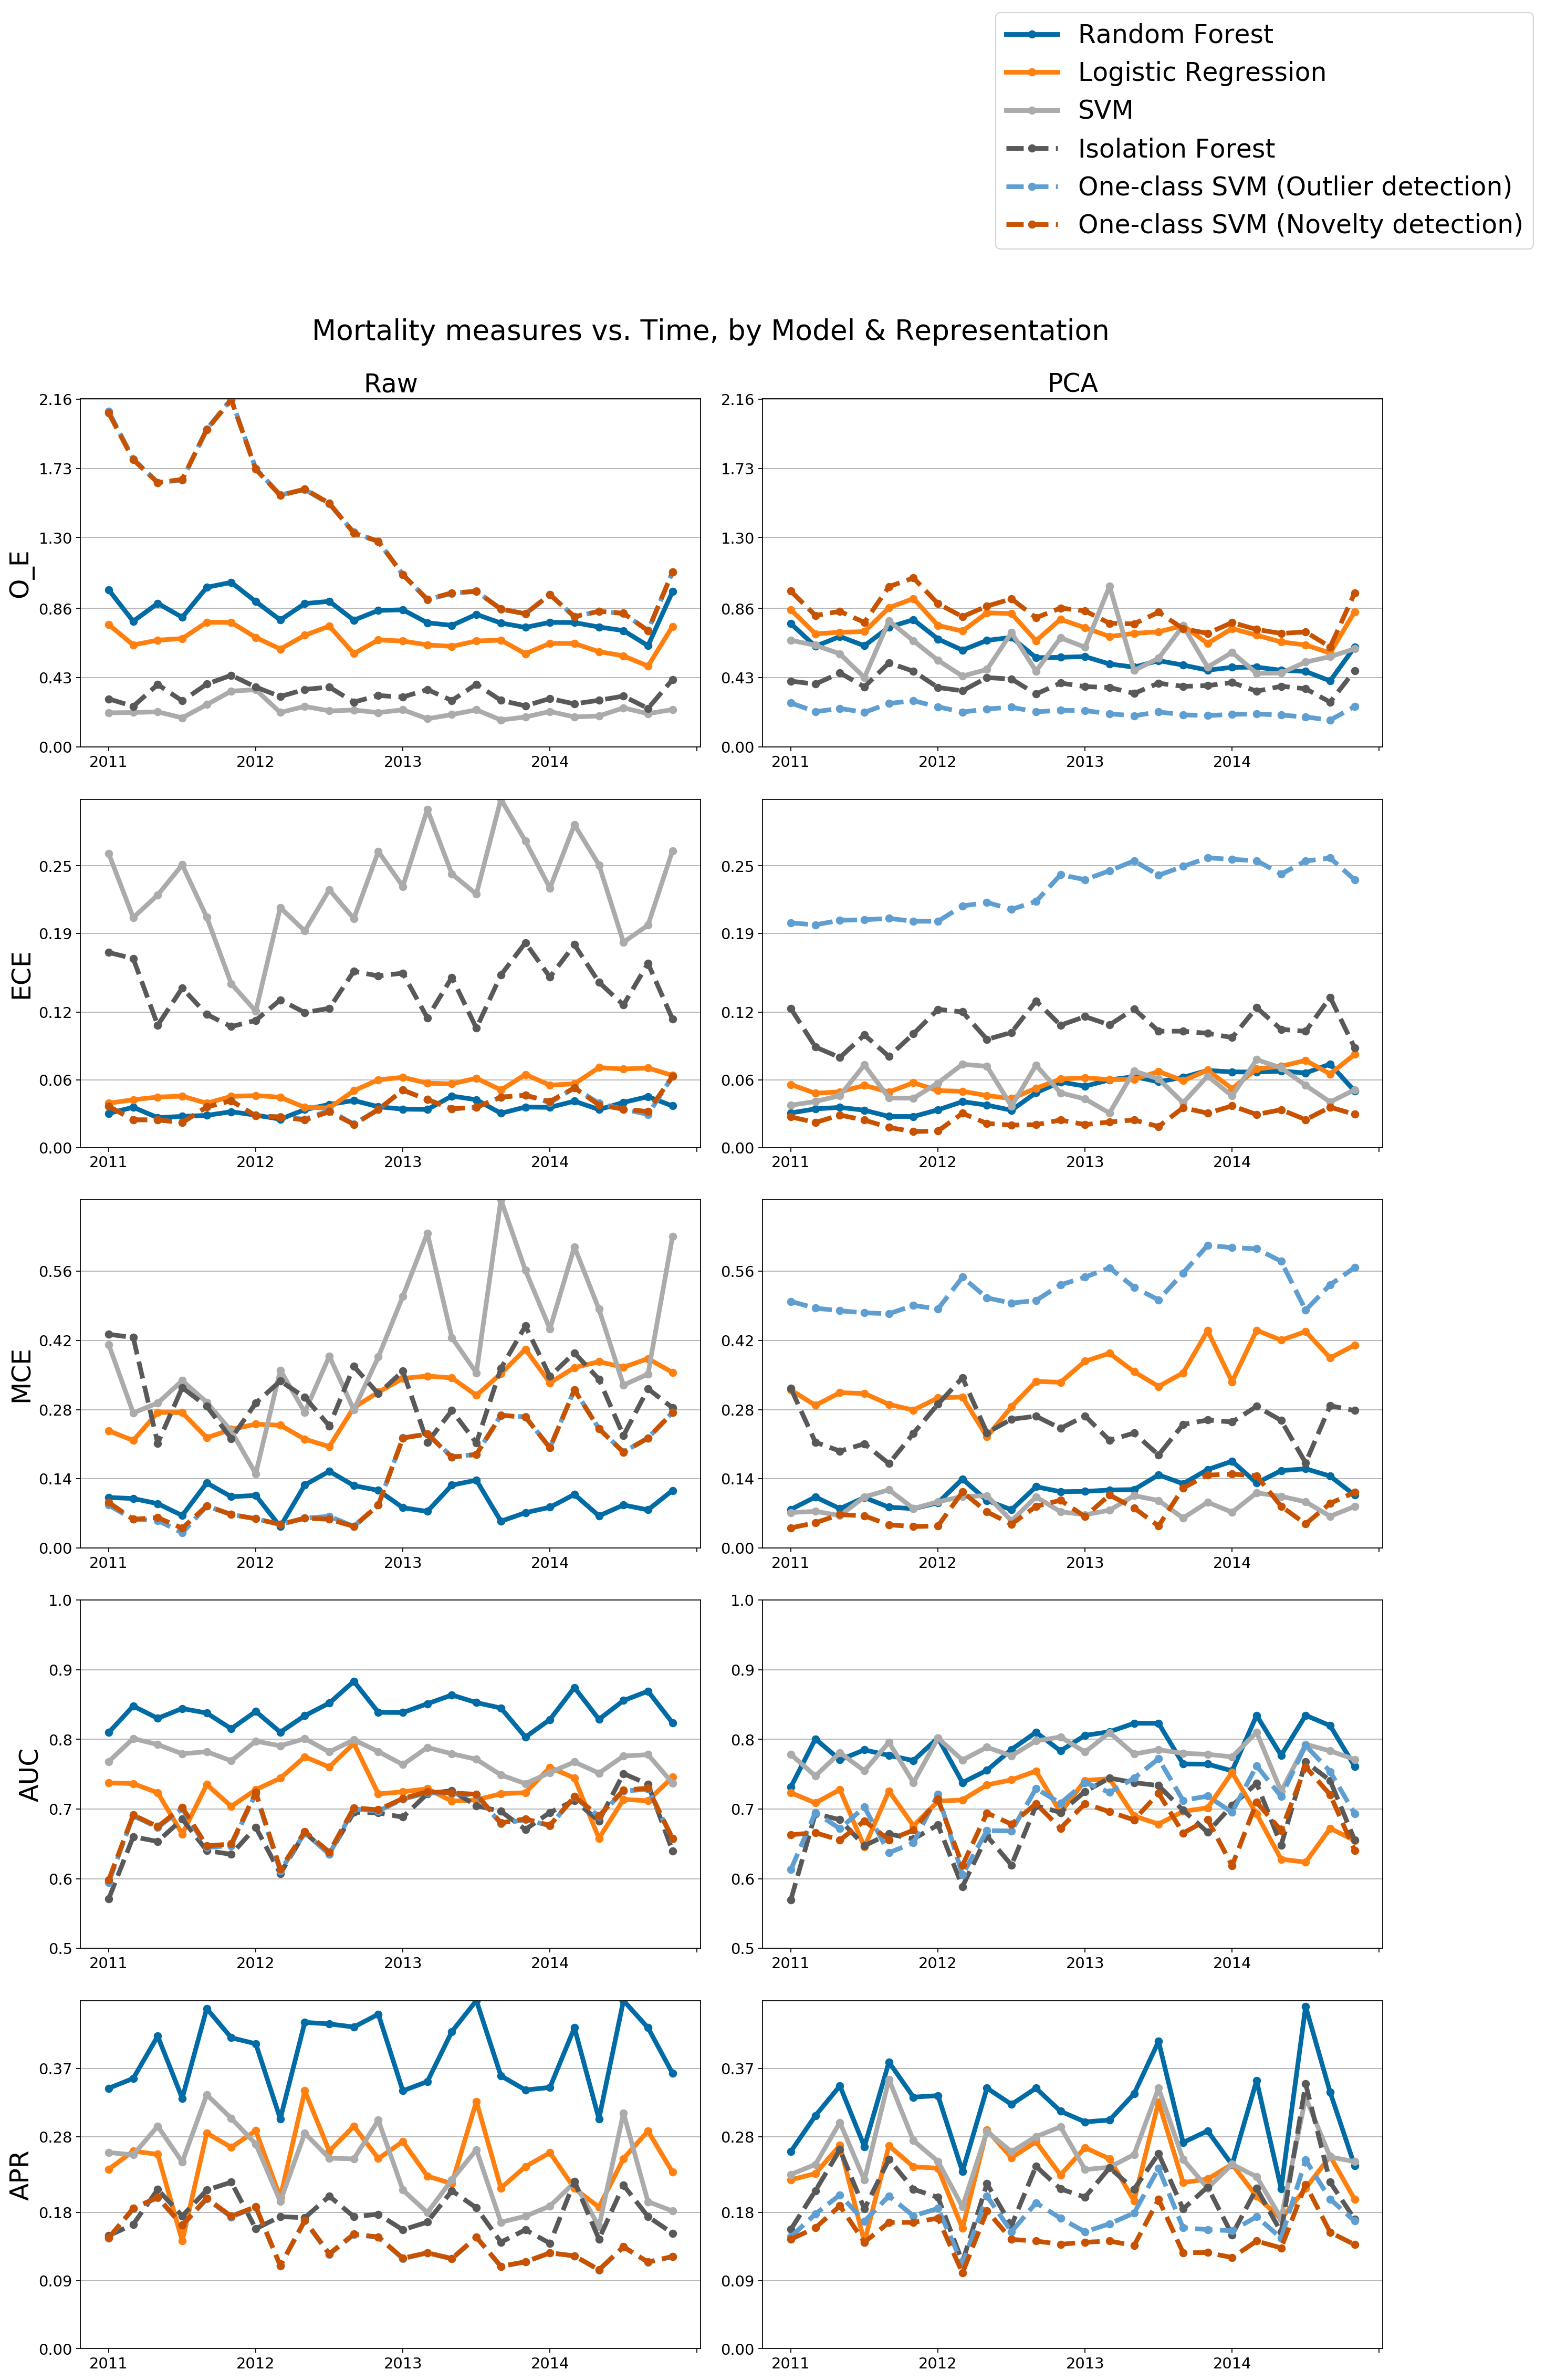

In [119]:
#for ticks
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
# minorLocator = MultipleLocator(1)

target='mort_icu'

fig=plt.figure(dpi=200)

fig, axs = plt.subplots(
    len(MEASURES), len(REPRESENTATIONS), sharex=False, sharey=False, figsize=(20, 32), dpi=160, facecolor='w', edgecolor='k'
)
plt.subplots_adjust(wspace=0.1, hspace=0.15, top=.85)

# orig_ticks=axs[0,0].get_yticks()
# print(orig_ticks)
# for i in range(len(MEASURES)):
#     for j in range(len(REPRESENTATIONS)):
#         axs[i,j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


for i, measure in enumerate(MEASURES):
    
    y_max = 0; y_min = 1
    for j, representation in enumerate(REPRESENTATIONS):
#         print(representation)
#         for modeltype in ['rf', 'lr', 'svm', 'rbf-svm', 'knn', 'mlp', 'lstm', 'gru']:
        colours = iter(['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
#         colours=iter(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']) #IBM
#         colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
#         colours=iter(['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255'])#tol
#         colours=iter(['#332288', '#44AA99', '#CC6677', '#882255'])
#         markers=iter(['solid', 'dashed','dashdot','dotted'])
#         markers=iter(['solid', 'solid','solid','solid'])
        linestyles=iter(['solid', 'solid','solid','dashed', 'dashed', 'dashed'])
        markers=iter(['o', 'o','o','o', 'o', 'o'])

        
        for modeltype in MODEL_TYPES:
#             years=averaged_df.index.tolist()
#             years=[year for year in years if year not in {2010}]

#             axs[i,j].set_xticks([2011, 2012, 2013, 2014])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
#             axs[i,j].set_xlim(2010.5, 2014.5)
#             axs[i,j].xaxis.set_minor_locator(minorLocator)
#             axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")

            axs[i,j].set_xticks(np.arange(0, averaged_df.shape[0]+1, 6).tolist()) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            axs[i,j].set_xticklabels(sorted(averaged_df.index.get_level_values('year').unique().tolist())) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

            means=averaged_df.loc[:, (target, modeltype, representation, measure)].values
#                 err=ste_df.loc[years, (target, modeltype, representation, train_style)].values
#                 print(years, means, err)
            c=next(colours)
            p=axs[i,j].plot(
#                     [x + 0.5 for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c, linestyle=next(markers),
                  [x for x in range(0, averaged_df.shape[0])], means, label=NAMES[modeltype],
                linewidth=4, color=c, marker=next(markers), linestyle=next(linestyles)
            )
            
            if (np.max(means) > y_max):
                y_max = np.max(means)
            if (np.min(means) < y_min):
                y_min = np.min(means)
    if (measure == 'AUC'):
        y_min = 0.5
        y_max = 1
    else:
        y_min = 0
    for j in range(0, len(REPRESENTATIONS)):
        axs[i,j].set_yticks(np.round(np.linspace(y_min,y_max,6),2).tolist()) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].set_ylim([y_min,y_max])


#             # Save just the portion _inside_ the second axis's boundaries
#             save_name=os.path.abspath("mort_icu-{}-{}.png".format(train_style, representation))
#             bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
#             fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
#             if (i==0)&(j==0):
#                 handles=0


                
for i, measure in enumerate(MEASURES):
    for j, representation in enumerate(REPRESENTATIONS):
#         axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].yaxis.grid() # horizontal lines
            
        axs[i,j].tick_params(labelsize=13)
        if i==0: axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0: axs[i,j].set_ylabel(measure, fontsize=22)

# handles, labels = axs[1,1].get_legend_handles_labels()
handles, labels = axs[0,0].get_legend_handles_labels()
# ax = fig.add_axes([0.8, 0.9, 0.1, 0.45])
# ax.set_axis_off()

# fig.legend(handles[3:], labels[3:], loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.legend(handles, labels, loc="upper right", fontsize=22)#, borderaxespad=0.2, bbox_to_anchor=(.7,.81))
fig.suptitle('Mortality measures vs. Time, by Model & Representation', fontsize=24, y=.88)


# plt.savefig('mort_icu-results.png', bbox_inches='tight')
plt.show()

<h2>Plots for length of stay > 3 days</h2>
<a id=los></a>

<Figure size 1200x800 with 0 Axes>

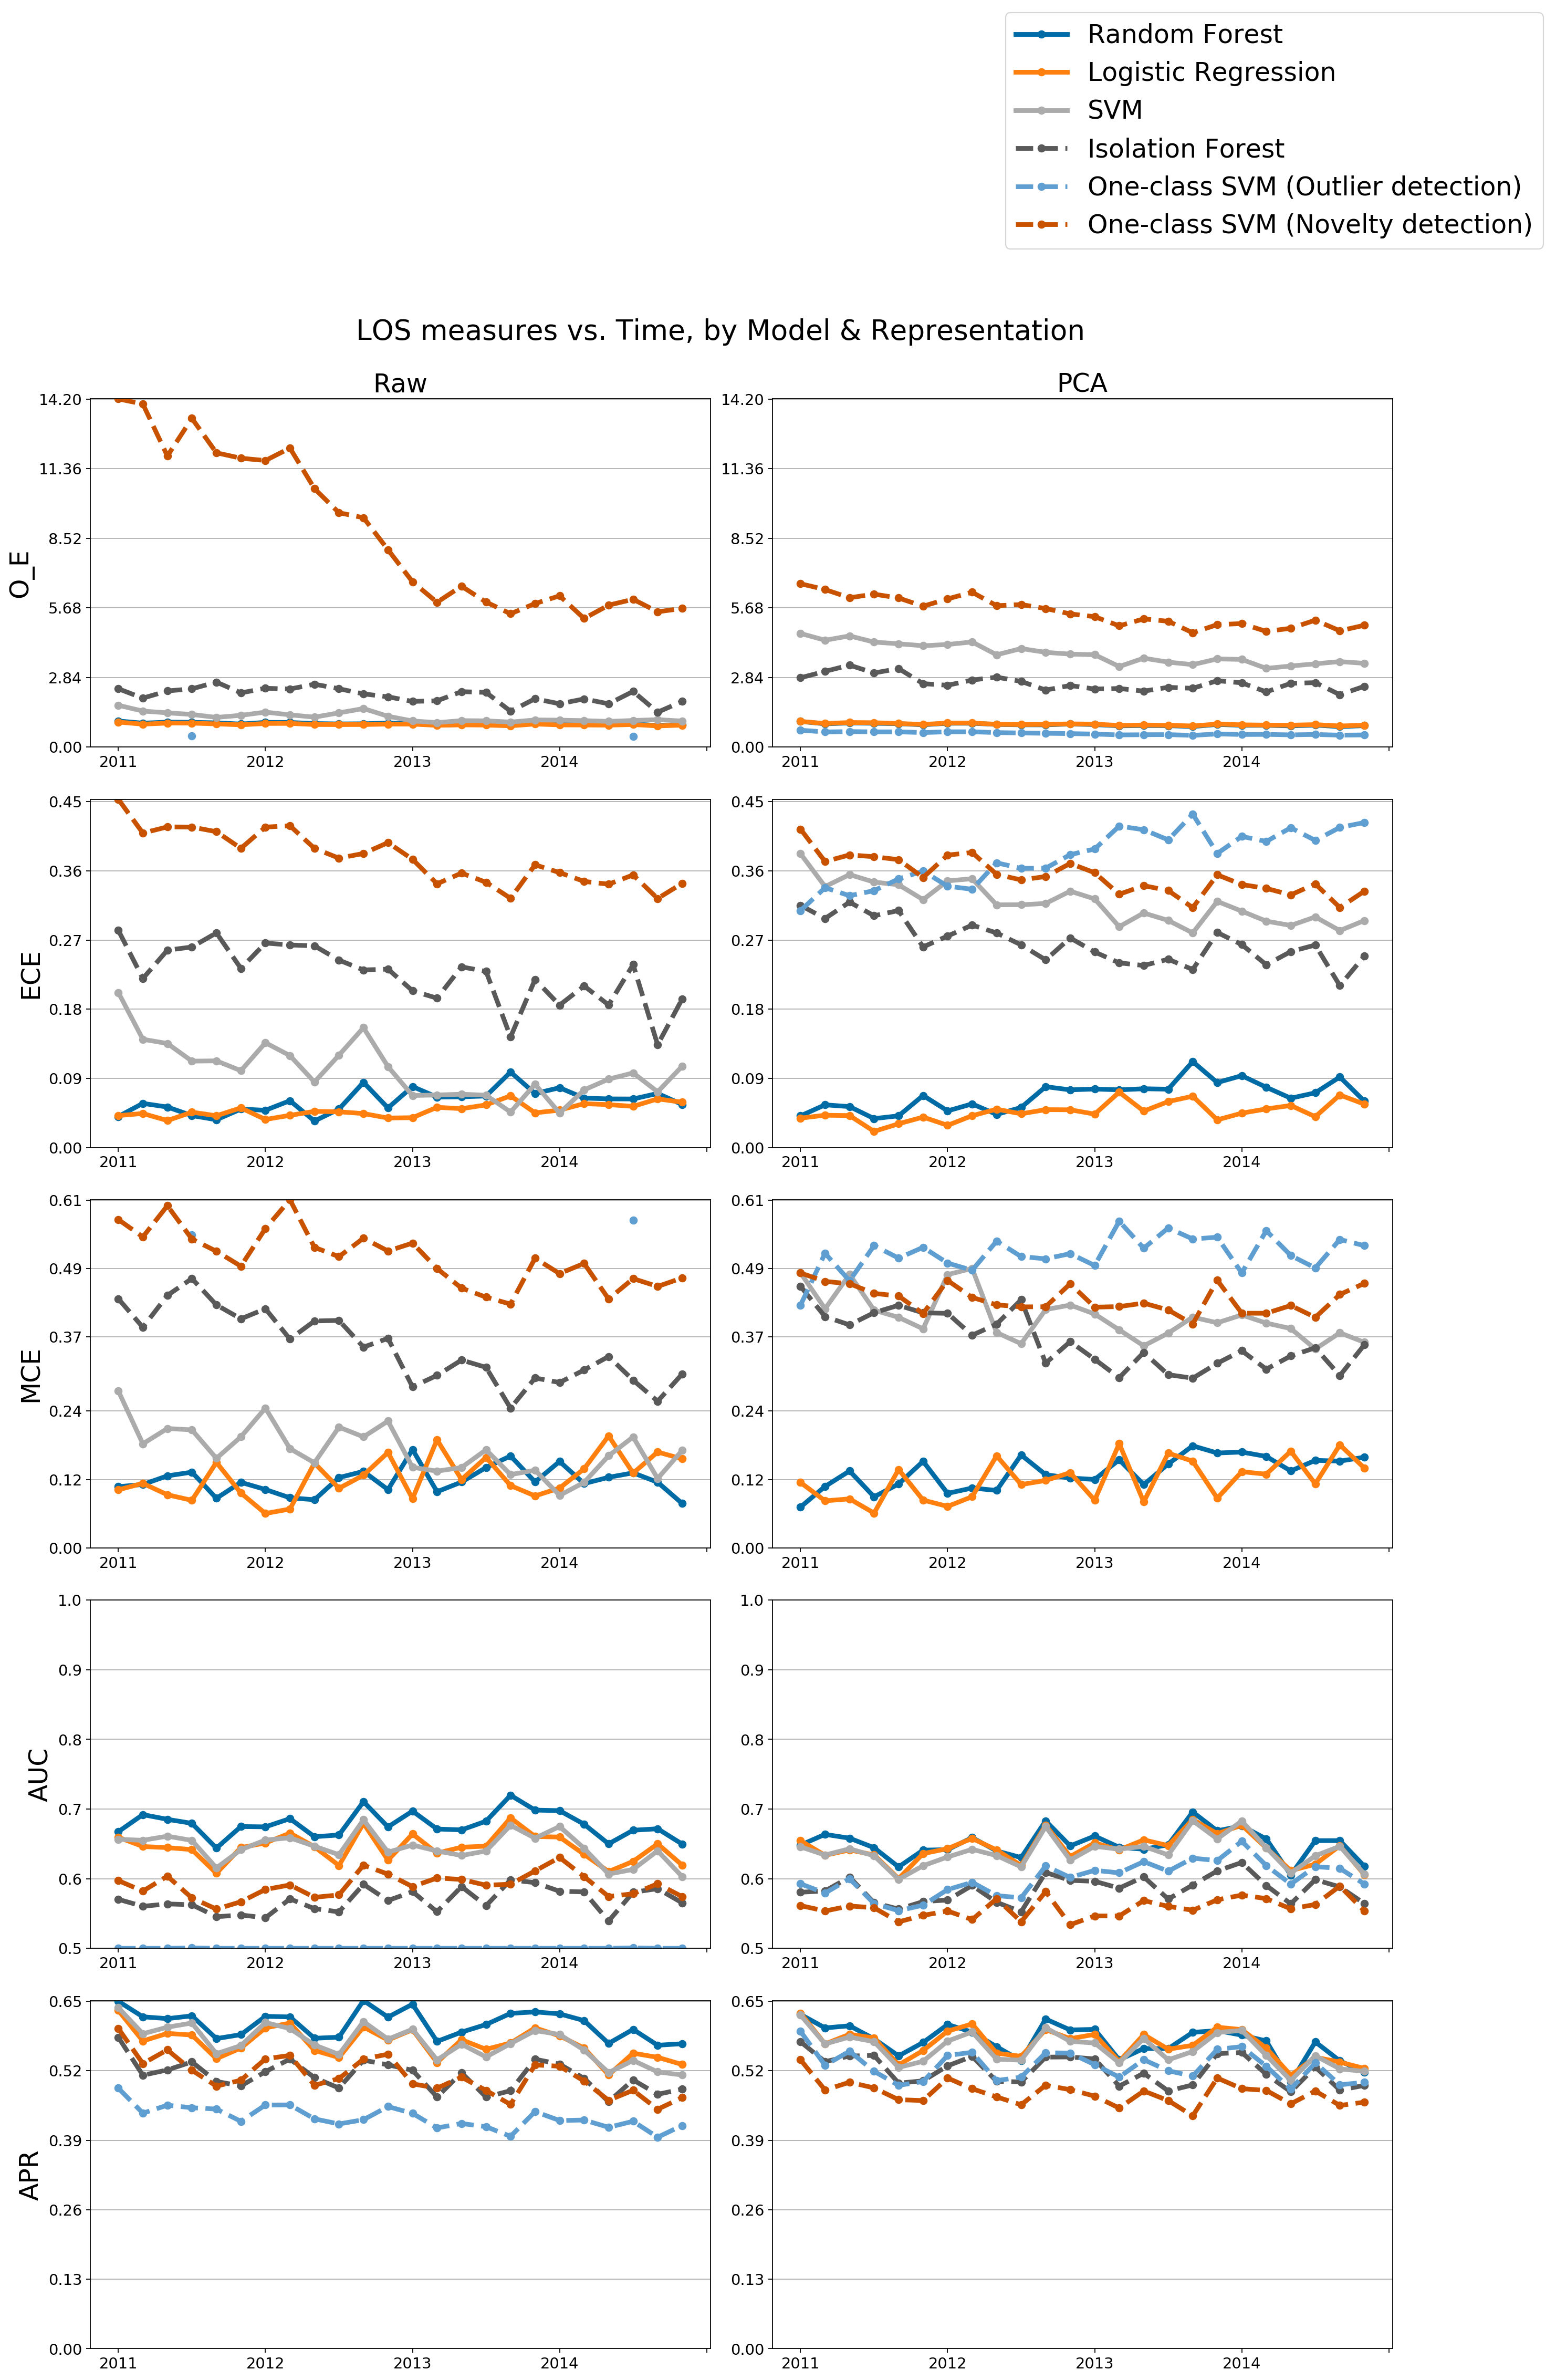

In [120]:
#for ticks
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
# minorLocator = MultipleLocator(1)

target='los_3'

fig=plt.figure(dpi=200)

fig, axs = plt.subplots(
    len(MEASURES), len(REPRESENTATIONS), sharex=False, sharey=False, figsize=(20, 32), dpi=160, facecolor='w', edgecolor='k'
)
plt.subplots_adjust(wspace=0.1, hspace=0.15, top=.85)

# orig_ticks=axs[0,0].get_yticks()
# print(orig_ticks)
# for i in range(len(MEASURES)):
#     for j in range(len(REPRESENTATIONS)):
#         axs[i,j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


for i, measure in enumerate(MEASURES):
    
    y_max = 0; y_min = 1
    for j, representation in enumerate(REPRESENTATIONS):
#         print(representation)
#         for modeltype in ['rf', 'lr', 'svm', 'rbf-svm', 'knn', 'mlp', 'lstm', 'gru']:
        colours = iter(['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
#         colours=iter(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']) #IBM
#         colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
#         colours=iter(['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255'])#tol
#         colours=iter(['#332288', '#44AA99', '#CC6677', '#882255'])
#         markers=iter(['solid', 'dashed','dashdot','dotted'])
#         markers=iter(['solid', 'solid','solid','solid'])
        linestyles=iter(['solid', 'solid','solid','dashed', 'dashed', 'dashed'])
        markers=iter(['o', 'o','o','o', 'o', 'o'])

        
        for modeltype in MODEL_TYPES:
#             years=averaged_df.index.tolist()
#             years=[year for year in years if year not in {2010}]

#             axs[i,j].set_xticks([2011, 2012, 2013, 2014])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
#             axs[i,j].set_xlim(2010.5, 2014.5)
#             axs[i,j].xaxis.set_minor_locator(minorLocator)
#             axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")

            axs[i,j].set_xticks(np.arange(0, averaged_df.shape[0]+1, 6).tolist()) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            axs[i,j].set_xticklabels(sorted(averaged_df.index.get_level_values('year').unique().tolist())) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

            means=averaged_df.loc[:, (target, modeltype, representation, measure)].values
#                 err=ste_df.loc[years, (target, modeltype, representation, train_style)].values
#                 print(years, means, err)
            c=next(colours)
            p=axs[i,j].plot(
#                     [x + 0.5 for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c, linestyle=next(markers),
                  [x for x in range(0, averaged_df.shape[0])], means, label=NAMES[modeltype],
                linewidth=4, color=c, marker=next(markers), linestyle=next(linestyles)
            )
            
            if (np.max(means) > y_max):
                y_max = np.max(means)
            if (np.min(means) < y_min):
                y_min = np.min(means)
    if (measure == 'AUC'):
        y_min = 0.5
        y_max = 1
    else:
        y_min = 0
    for j in range(0, len(REPRESENTATIONS)):
        axs[i,j].set_yticks(np.round(np.linspace(y_min,y_max,6),2).tolist()) #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].set_ylim([y_min,y_max])


#             # Save just the portion _inside_ the second axis's boundaries
#             save_name=os.path.abspath("mort_icu-{}-{}.png".format(train_style, representation))
#             bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
#             fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
#             if (i==0)&(j==0):
#                 handles=0


                
for i, measure in enumerate(MEASURES):
    for j, representation in enumerate(REPRESENTATIONS):
#         axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].yaxis.grid() # horizontal lines
            
        axs[i,j].tick_params(labelsize=13)
        if i==0: axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0: axs[i,j].set_ylabel(measure, fontsize=22)

# handles, labels = axs[1,1].get_legend_handles_labels()
handles, labels = axs[0,0].get_legend_handles_labels()
# ax = fig.add_axes([0.8, 0.9, 0.1, 0.45])
# ax.set_axis_off()

# fig.legend(handles[3:], labels[3:], loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.legend(handles, labels, loc="upper right", fontsize=22)#, borderaxespad=0.2, bbox_to_anchor=(.7,.81))
fig.suptitle('LOS measures vs. Time, by Model & Representation', fontsize=24, y=.88)


# plt.savefig('mort_icu-results.png', bbox_inches='tight')
plt.show()

[0.  0.2 0.4 0.6 0.8 1. ]


<Figure size 1200x800 with 0 Axes>

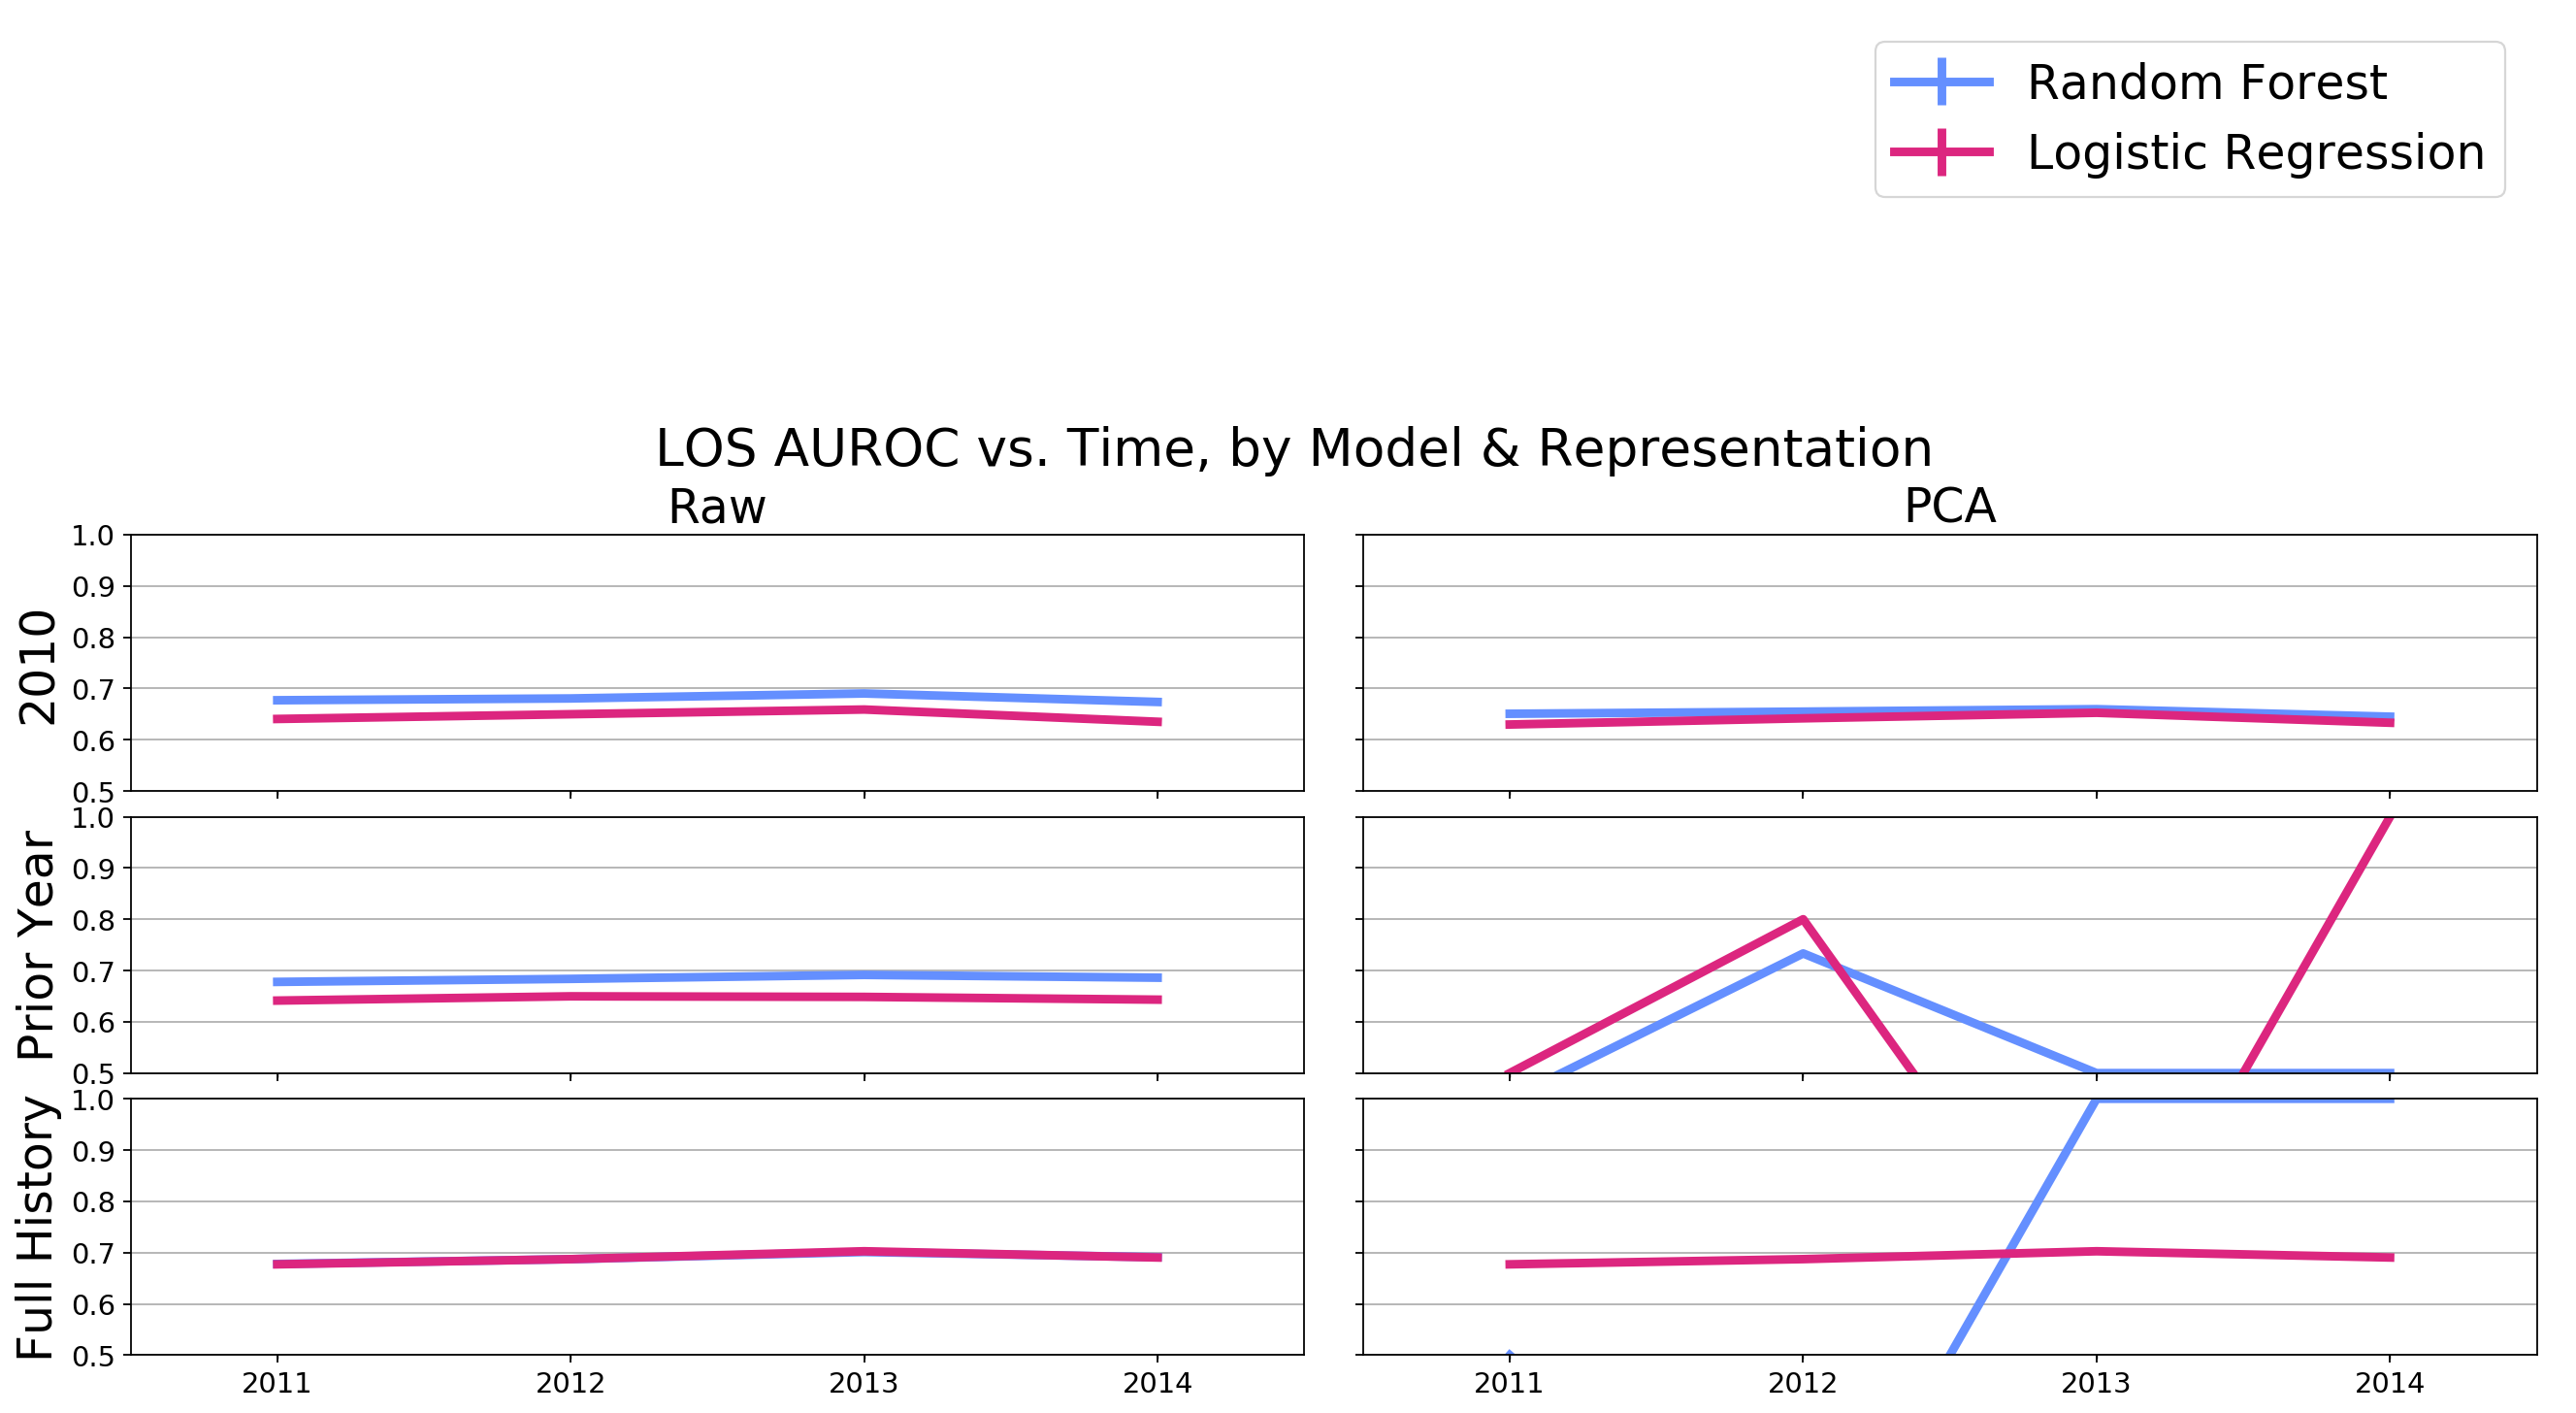

In [83]:
#for ticks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
minorLocator = MultipleLocator(1)

target='los_3'

fig=plt.figure(dpi=200)

fig, axs = plt.subplots(
    len(TRAIN_STYLES), len(MODEL_TYPES), sharex=True, sharey=True, figsize=(20, 7), dpi=160, facecolor='w', edgecolor='k'
)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

orig_ticks=axs[0,0].get_yticks()
print(orig_ticks)
for i in range(len(TRAIN_STYLES)):
    for j in range(len(MODEL_TYPES)):
        axs[i,j].set_yticks([])

for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
#         for modeltype in ['rf', 'lr', 'svm', 'rbf-svm', 'knn', 'mlp', 'lstm', 'gru']:
        colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
        for modeltype in MODEL_TYPES:
            years=averaged_df.index.tolist()
            years=[year for year in years if year not in {2010}]
#             if i==0:
#                 axs[i,j].set_title(representation)
#             if j==0:
#                 ylabel=train_style
#                 if ylabel=='GH':
#                     ylabel='2001-2002'
#                 axs[i,j].set_ylabel(ylabel)
#             axs[i,j].set_yticks(orig_ticks)
            axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            axs[i,j].set_xticks([2011, 2012, 2013, 2014])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
            axs[i,j].set_xlim(2010.5, 2014.5)
            axs[i,j].set_ylim([0.5,1.0])
            axs[i,j].xaxis.set_minor_locator(minorLocator)
#             axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
            c=next(colours)
            try:
                means=averaged_df.loc[years, (target, modeltype, representation, train_style)].values
                err=ste_df.loc[years, (target, modeltype, representation, train_style)].values
#                 print(years, means, err)
                gh_plot=axs[i,j].errorbar(
#                     [x + 0.5 for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c,
                      [x for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c,

                )
                
            except:
                pass
#             # Save just the portion _inside_ the second axis's boundaries
            save_name=os.path.abspath("los_3-{}-{}.png".format(train_style, representation))
            bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
            fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
            if (i==0)&(j==0):
                handles=0

#             try:
#                 lineheight=averaged_static_df.loc[0, (modeltype, representation, 'AUC')]
#                 axs[j,i].axhline(linewidth=4, color='r')
        

for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].yaxis.grid() # horizontal lines
        
#         if j == 0: axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#         else: axs[i, j].set_yticks([])
#         if i != 2: axs[i, j].set_xticks([])
            
        axs[i,j].tick_params(labelsize=13)
        if i==0: axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0: axs[i,j].set_ylabel(NAMES[train_style], fontsize=22)
    
handles, labels = axs[0,0].get_legend_handles_labels()
ax = fig.add_axes([0.8, 0.9, 0.1, 0.45])
ax.set_axis_off()

fig.legend(handles, labels, loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.suptitle('LOS AUROC vs. Time, by Model & Representation', fontsize=24)


plt.savefig('los_3-results.png', bbox_inches='tight')
plt.show()

# AUPRC plots

In [70]:


# df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')


metric='APR'
averaged_df=df.groupby('year').mean().loc[:, (slice(None), slice(None), slice(None), slice(None), metric)]
ste_df=df.groupby('year').std().loc[:, (slice(None), slice(None), slice(None), slice(None), metric)]/np.sqrt(5)
averaged_static_df=no_years_df.mean()

averaged_df.columns = averaged_df.columns.droplevel(-1)
ste_df.columns = ste_df.columns.droplevel(-1)


<h2>Plots for Mortality</h2>
<a id=mortality></a>

This block of code produces subplots with shared x axes and y axes in the range of 0.5-1 for all AUCs on the task of mortality

In [66]:
TRAIN_STYLES    = ['first-years', 'Rolling_limited', 'Rolling']
REPRESENTATIONS = ['itemid', 'pca']#, 'nlp', 'Level2']
MODEL_TYPES     = ['rf', 'lr']#, 'lstm', 'grud']

NAMES = {
    'first-years': '2010',
    'Rolling': 'Full History',
    'Rolling_limited': 'Prior Year',
    'itemid': 'Raw',
    'pca': 'PCA',
    'umap': 'UMAP',
    'nlp': 'CUI Code Spanning',
    'Level2': 'Clinical Aggregations',
    'rf': 'Random Forest',
    'lr': 'Logistic Regression',
    'lstm': 'LSTM',
    'grud': 'GRU-D'
}


In [74]:
np.arange(0,1.2,.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

[0.  0.2 0.4 0.6 0.8 1. ]
itemid
[2011, 2012, 2013, 2014] [0.36273518 0.37409344 0.35878927 0.3722273 ] [nan nan nan nan]
[2011, 2012, 2013, 2014] [0.20477755 0.22181636 0.21688374 0.20586688] [nan nan nan nan]
pca
[2011, 2012, 2013, 2014] [0.36273518 0.37409344 0.35878927 0.3722273 ] [nan nan nan nan]
[2011, 2012, 2013, 2014] [0.57940448 0.57929278 0.57424001 0.54650095] [nan nan nan nan]
itemid
[2011, 2012, 2013, 2014] [0.36273518 0.39955112 0.42105188 0.39839182] [nan nan nan nan]
[2011, 2012, 2013, 2014] [0.22817887 0.2254034  0.24909909 0.22125992] [nan nan nan nan]
pca
[2011, 2012, 2013, 2014] [0.36273518 0.39955112 0.42105188 0.39839182] [nan nan nan nan]
[2011, 2012, 2013, 2014] [0.22817887 0.2254034  0.24909909 0.22125992] [nan nan nan nan]
itemid
[2011, 2012, 2013, 2014] [0.23202351 0.29857449 0.33133847 0.33308477] [nan nan nan nan]
[2011, 2012, 2013, 2014] [0.20477755 0.30797039 0.33108837 0.32249402] [nan nan nan nan]
pca
[2011, 2012, 2013, 2014] [0.23202351 0.29857449 0.3

<Figure size 1200x800 with 0 Axes>

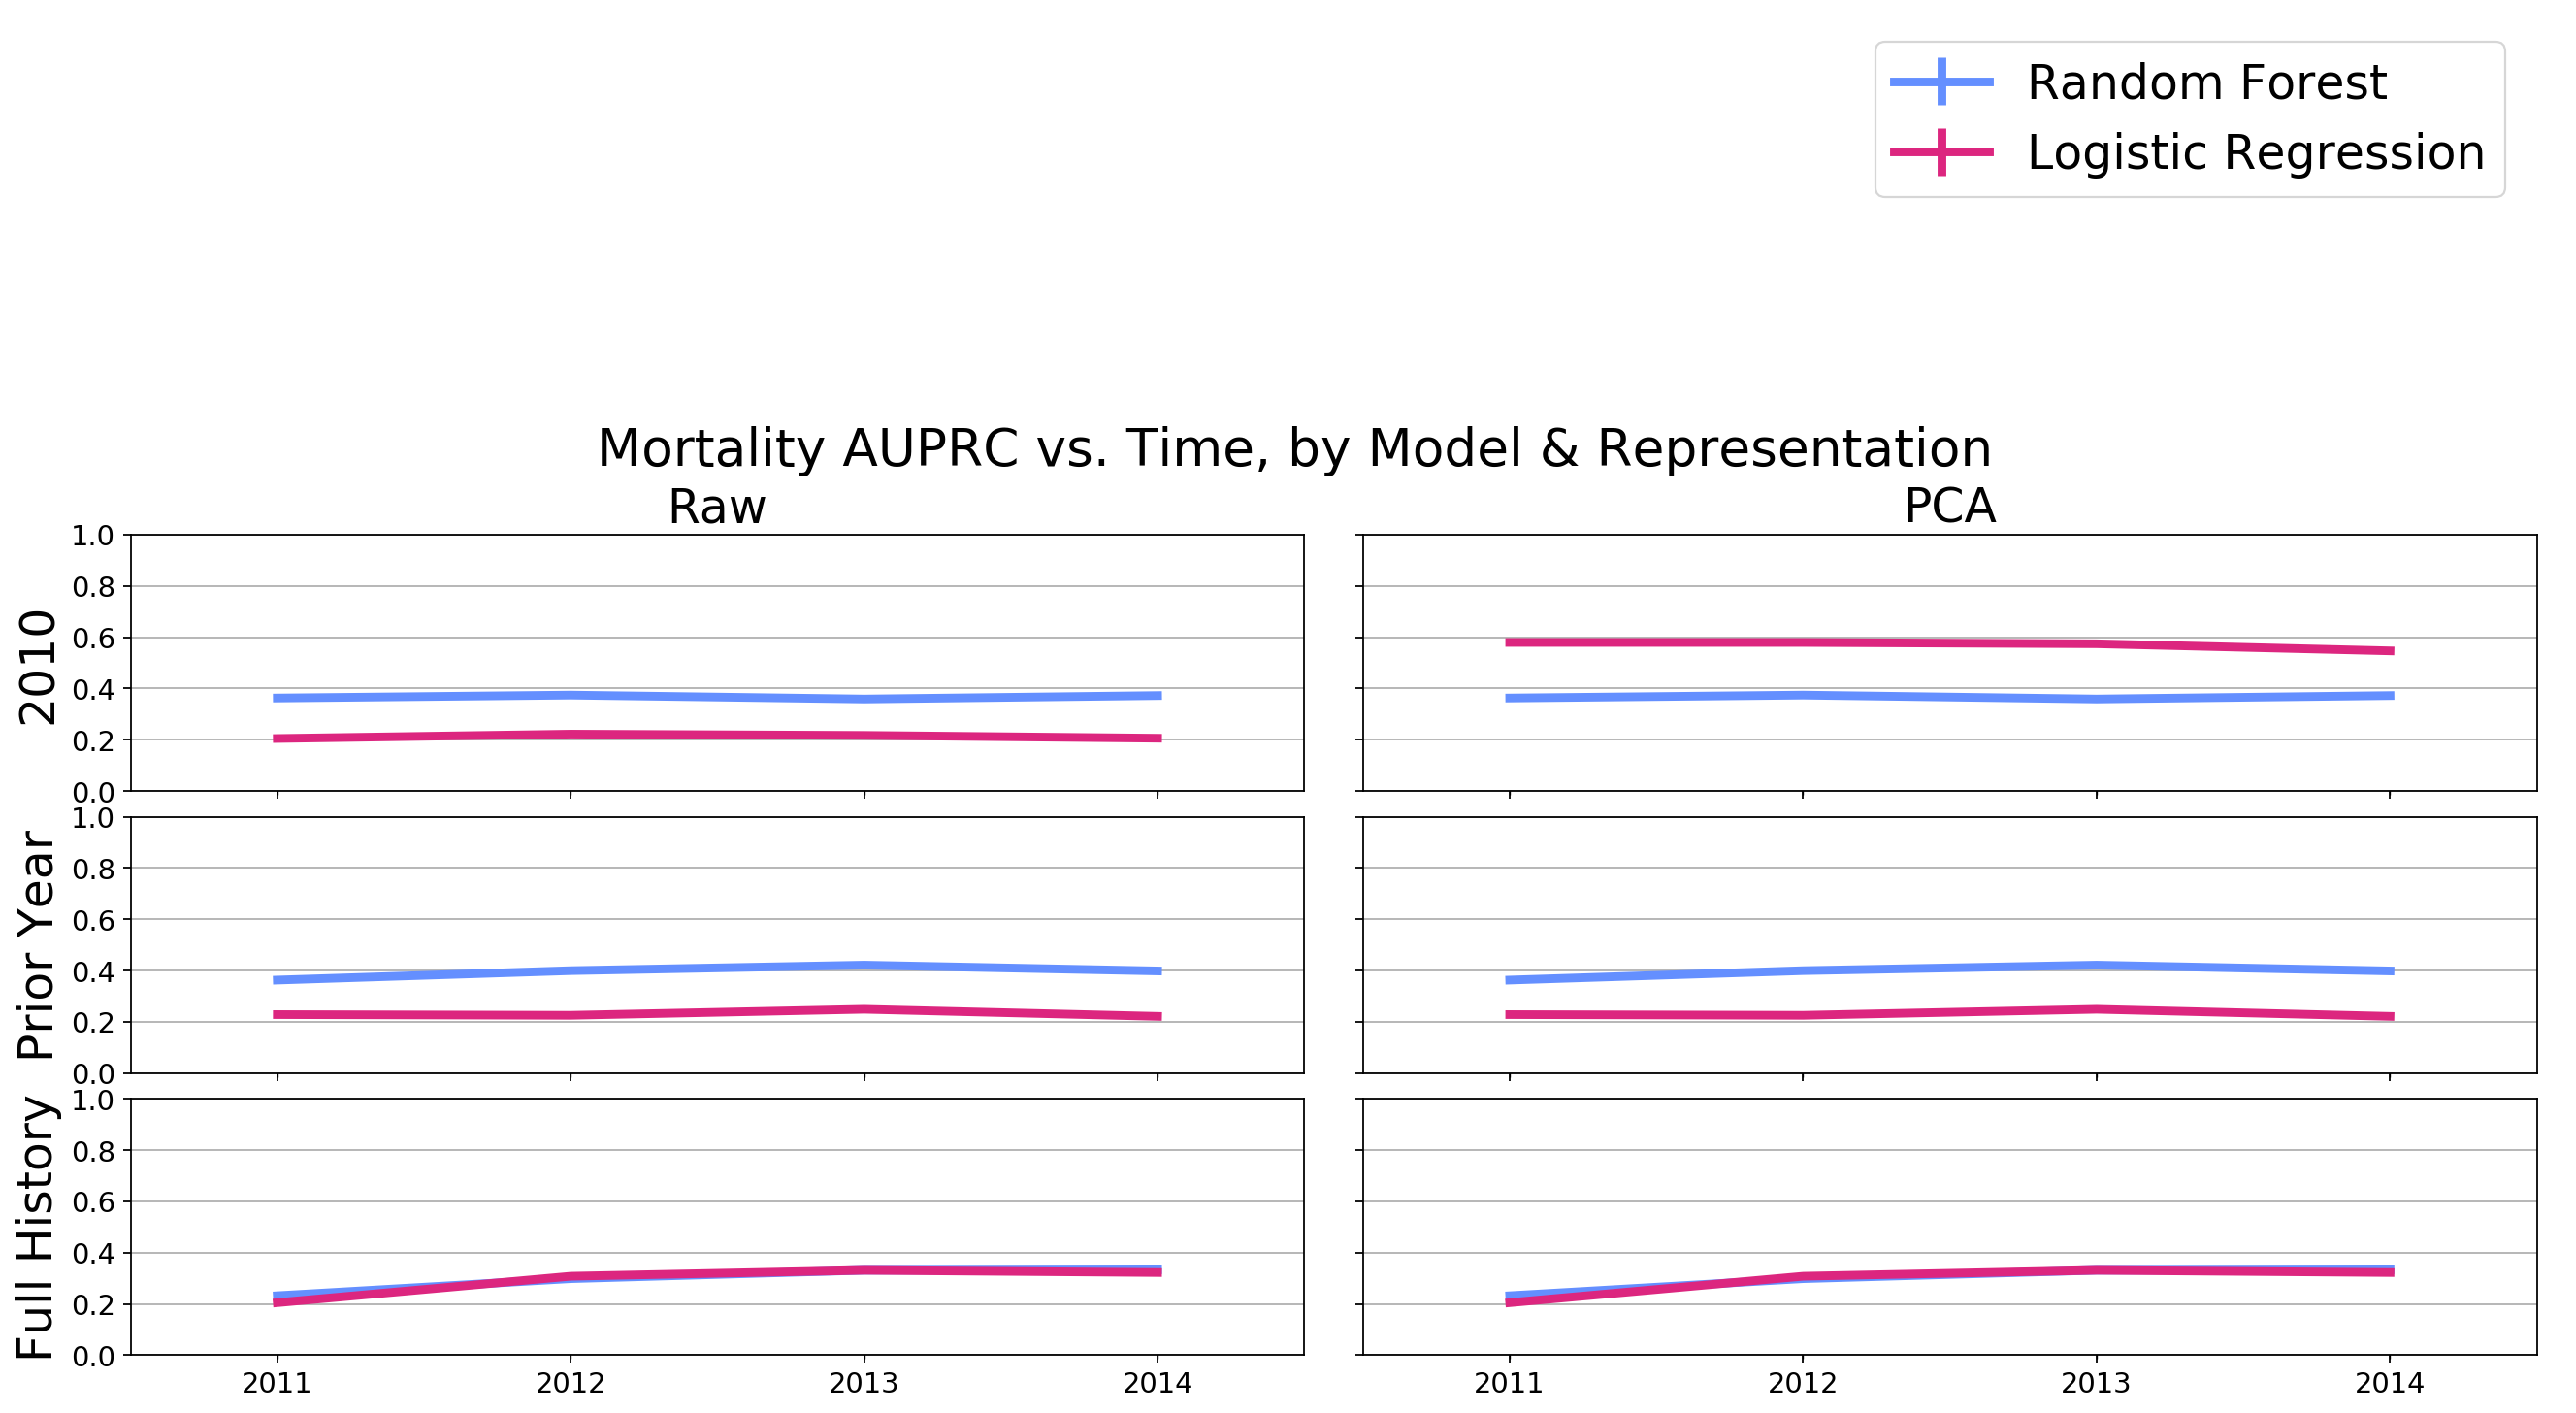

In [75]:
#for ticks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
minorLocator = MultipleLocator(1)

target='mort_icu'

fig=plt.figure(dpi=200)

fig, axs = plt.subplots(
    len(TRAIN_STYLES), len(MODEL_TYPES), sharex=True, sharey=True, figsize=(20, 7), dpi=160, facecolor='w', edgecolor='k'
)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

orig_ticks=axs[0,0].get_yticks()
print(orig_ticks)
for i in range(len(TRAIN_STYLES)):
    for j in range(len(MODEL_TYPES)):
        axs[i,j].set_yticks([])



for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
        print(representation)
#         for modeltype in ['rf', 'lr', 'svm', 'rbf-svm', 'knn', 'mlp', 'lstm', 'gru']:
        colours = iter(['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
#         colours=iter(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']) #IBM
        colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
#         colours=iter(['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255'])#tol
#         colours=iter(['#332288', '#44AA99', '#CC6677', '#882255'])
        markers=iter(['solid', 'dashed','dashdot','dotted'])
        markers=iter(['solid', 'solid','solid','solid'])
        for modeltype in MODEL_TYPES:
            years=averaged_df.index.tolist()
            years=[year for year in years if year not in {2010}]



            axs[i,j].set_yticks(np.arange(0,1.2,.2))
            axs[i,j].set_xticks([2011, 2012, 2013, 2014])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
            axs[i,j].set_xlim(2010.5, 2014.5)
            axs[i,j].set_ylim([0.5,1.0])
            axs[i,j].xaxis.set_minor_locator(minorLocator)
#             axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
            try:
                means=averaged_df.loc[years, (target, modeltype, representation, train_style)].values
                err=ste_df.loc[years, (target, modeltype, representation, train_style)].values
                print(years, means, err)
                c=next(colours)
                gh_plot=axs[i,j].errorbar(
#                     [x + 0.5 for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c, linestyle=next(markers),
                      [x for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c, linestyle=next(markers),

                )
                
            except:
                pass
#             # Save just the portion _inside_ the second axis's boundaries
            save_name=os.path.abspath("mort_icu-{}-{}.png".format(train_style, representation))
            bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
            fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
            if (i==0)&(j==0):
                handles=0


                
for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
        axs[i,j].set_yticks(np.arange(0,1.2,.2))
        axs[i,j].yaxis.grid() # horizontal lines

        
            
        axs[i,j].tick_params(labelsize=13)
        if i==0: axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0: axs[i,j].set_ylabel(NAMES[train_style], fontsize=22)

# handles, labels = axs[1,1].get_legend_handles_labels()
handles, labels = axs[0,0].get_legend_handles_labels()
ax = fig.add_axes([0.8, 0.9, 0.1, 0.45])
ax.set_axis_off()

# fig.legend(handles[3:], labels[3:], loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.legend(handles, labels, loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.suptitle('Mortality AUPRC vs. Time, by Model & Representation', fontsize=24)


plt.savefig('mort_icu-results.png', bbox_inches='tight')
plt.show()

<h2>Plots for length of stay > 3 days</h2>
<a id=los></a>

[0.  0.2 0.4 0.6 0.8 1. ]


<Figure size 1200x800 with 0 Axes>

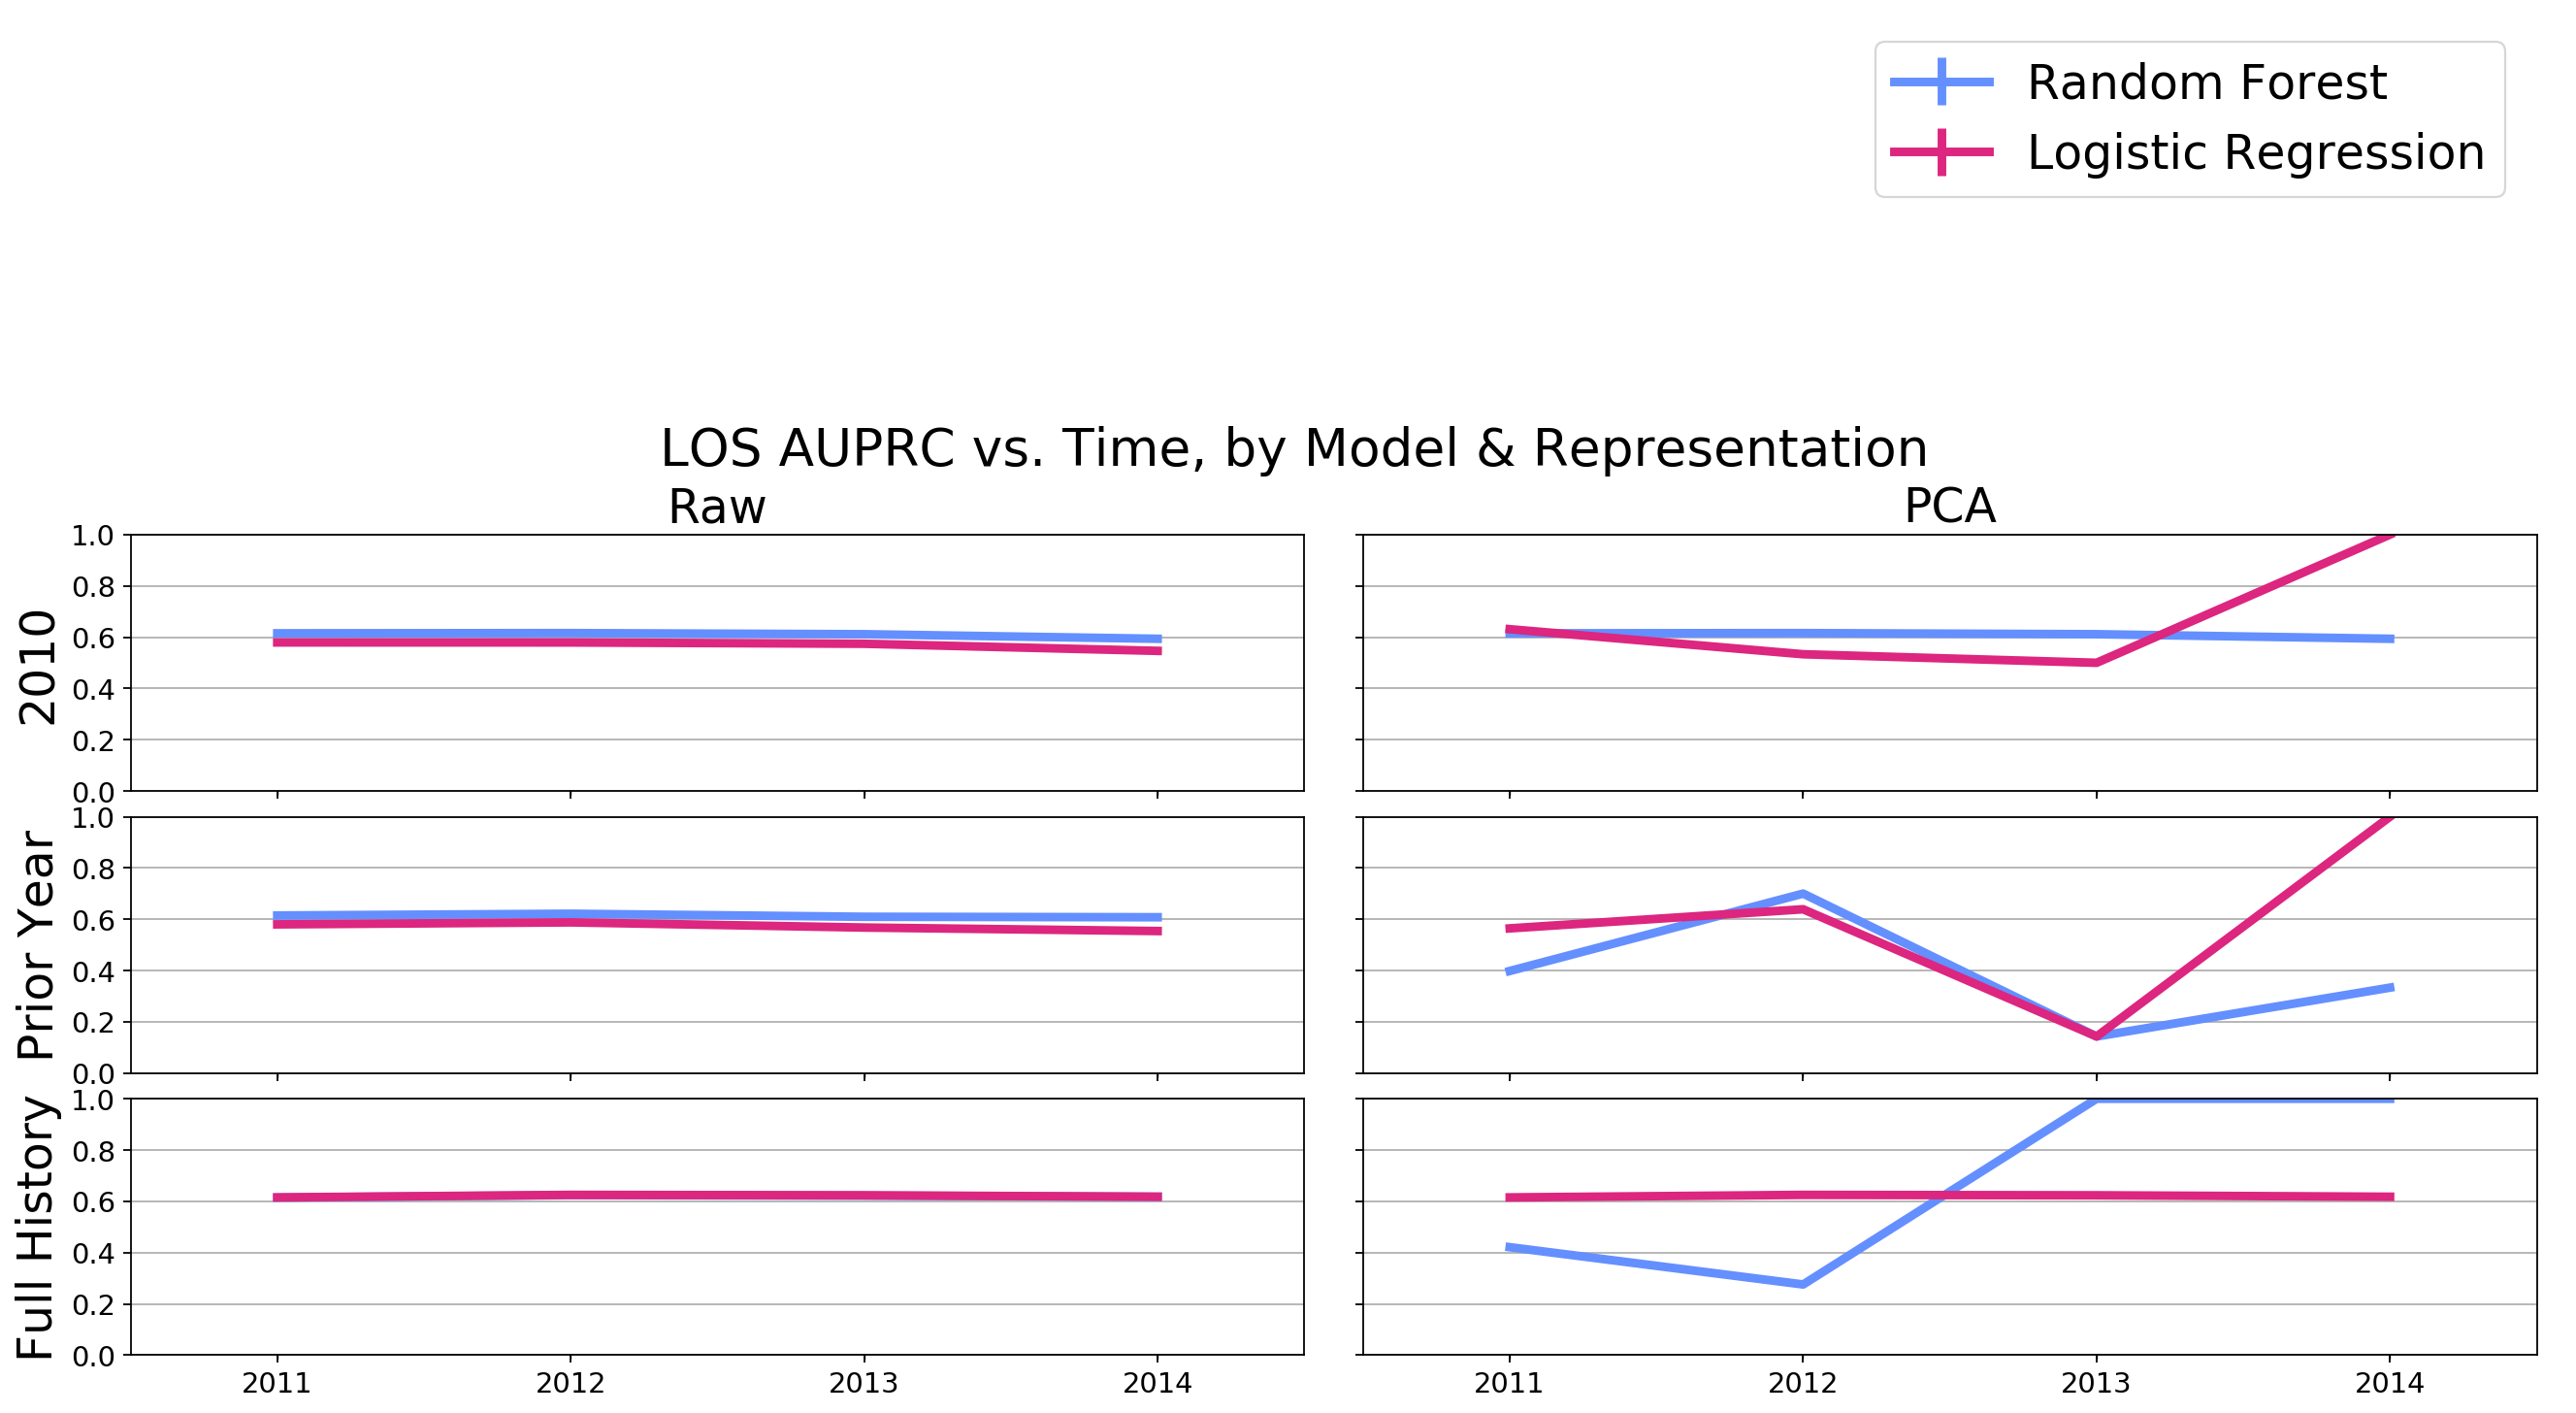

In [76]:
#for ticks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
minorLocator = MultipleLocator(1)

target='los_3'

fig=plt.figure(dpi=200)

fig, axs = plt.subplots(
    len(TRAIN_STYLES), len(MODEL_TYPES), sharex=True, sharey=True, figsize=(20, 7), dpi=160, facecolor='w', edgecolor='k'
)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

orig_ticks=axs[0,0].get_yticks()
print(orig_ticks)
for i in range(len(TRAIN_STYLES)):
    for j in range(len(MODEL_TYPES)):
        axs[i,j].set_yticks([])

for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
#         for modeltype in ['rf', 'lr', 'svm', 'rbf-svm', 'knn', 'mlp', 'lstm', 'gru']:
        colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
        for modeltype in MODEL_TYPES:
            years=averaged_df.index.tolist()
            years=[year for year in years if year not in {2010}]
#             if i==0:
#                 axs[i,j].set_title(representation)
#             if j==0:
#                 ylabel=train_style
#                 if ylabel=='GH':
#                     ylabel='2001-2002'
#                 axs[i,j].set_ylabel(ylabel)
#             axs[i,j].set_yticks(orig_ticks)
            axs[i,j].set_yticks(np.arange(0,1.2,.2))
            axs[i,j].set_xticks([2011, 2012, 2013, 2014])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
            axs[i,j].set_xlim(2010.5, 2014.5)
            axs[i,j].set_ylim([0.5,1.0])
            axs[i,j].xaxis.set_minor_locator(minorLocator)
#             axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
            c=next(colours)
            try:
                means=averaged_df.loc[years, (target, modeltype, representation, train_style)].values
                err=ste_df.loc[years, (target, modeltype, representation, train_style)].values
#                 print(years, means, err)
                gh_plot=axs[i,j].errorbar(
#                     [x + 0.5 for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c,
                      [x for x in years],means,err, label=NAMES[modeltype], linewidth=4, color=c,

                )
                
            except:
                pass
#             # Save just the portion _inside_ the second axis's boundaries
            save_name=os.path.abspath("los_3-{}-{}.png".format(train_style, representation))
            bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
            fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
            if (i==0)&(j==0):
                handles=0

#             try:
#                 lineheight=averaged_static_df.loc[0, (modeltype, representation, 'AUC')]
#                 axs[j,i].axhline(linewidth=4, color='r')
        

for i, train_style in enumerate(TRAIN_STYLES):
    for j, representation in enumerate(REPRESENTATIONS):
        axs[i,j].set_yticks(np.arange(0,1.2,.2))
        axs[i,j].yaxis.grid() # horizontal lines
        
#         if j == 0: axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#         else: axs[i, j].set_yticks([])
#         if i != 2: axs[i, j].set_xticks([])
            
        axs[i,j].tick_params(labelsize=13)
        if i==0: axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0: axs[i,j].set_ylabel(NAMES[train_style], fontsize=22)
    
handles, labels = axs[0,0].get_legend_handles_labels()
ax = fig.add_axes([0.8, 0.9, 0.1, 0.45])
ax.set_axis_off()

fig.legend(handles, labels, loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.27), fontsize=22)
fig.suptitle('LOS AUPRC vs. Time, by Model & Representation', fontsize=24)


plt.savefig('los_3-results.png', bbox_inches='tight')
plt.show()

In [ ]:
# tabular mortality results
metric='AUC'
# metric='APR'
# target='mort_icu'
target='los_3'

idx=pd.IndexSlice

# display(df.loc[idx[:, list(range(2002,2013))], :].head(5))
# display(no_years_df.head(5))
print('For year agnostic performance')
print(metric, target)
print("\n")

for model in ['lr', 'rf', 'lstm', 'grud']:
    all_scores=no_years_df.loc[:, idx[target, model, 'itemid', metric]].values
    m_raw=np.mean(all_scores)
    s_raw=np.std(all_scores)
    all_scores=no_years_df.loc[:, idx[target, model, 'pca', metric]].values
    m_pca=np.mean(all_scores)
    s_pca=np.std(all_scores)
    all_scores=no_years_df.loc[:, idx[target, model, 'nlp', metric]].values
    m_nlp=np.mean(all_scores)
    s_nlp=np.std(all_scores)
    all_scores=no_years_df.loc[:, idx[target, model, 'Level2', metric]].values
    m_clin=np.mean(all_scores)
    s_clin=np.std(all_scores)
    print('{} & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ \\\\'.format(model.upper(), m_raw, s_raw, m_pca, s_pca, m_nlp, s_nlp, m_clin, s_clin))
                               
print("\n")
print('For Rolling average performance/year')
print("\n")
for model in ['lr', 'rf', 'lstm', 'grud']:
    all_scores=df.loc[idx[:, list(range(2002,2013))], :].groupby('year').mean().loc[:, (target, model, 'itemid', 'Rolling', metric)].values
    m_raw=np.mean(all_scores)
    s_raw=np.std(all_scores)
    all_scores=df.loc[idx[:, list(range(2002,2013))], :].groupby('year').mean().loc[:, (target, model, 'pca', 'Rolling', metric)].values
    m_pca=np.mean(all_scores)
    s_pca=np.std(all_scores)
    all_scores=df.loc[idx[:, list(range(2002,2013))], :].groupby('year').mean().loc[:, (target, model, 'nlp', 'Rolling', metric)].values
    m_nlp=np.mean(all_scores)
    s_nlp=np.std(all_scores)
    all_scores=df.loc[idx[:, list(range(2002,2013))], :].groupby('year').mean().loc[:, (target, model, 'Level2', 'Rolling', metric)].values
    m_clin=np.mean(all_scores)
    s_clin=np.std(all_scores)
    
    print('{} & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ \\\\'.format(model.upper(), m_raw, s_raw, m_pca, s_pca, m_nlp, s_nlp, m_clin, s_clin))
    
#     m_raw_no=no_years_df
#     max_loss_raw, max_loss_clinical=0.24, 0.32,
#     print('{} & ${:.2f} \\pm {:.2f}$ \& ${:.2f} \\pm {:.2f}$ \&\&\& {:.2f} & {:.2f} \\\\'.format(model.upper(), m_raw,s_raw, m_clin, s_clin, max_loss_raw, max_loss_clinical))

print('\n For Average AUROC rolling and max delta AUROC \n')

for model in ['lr', 'rf', 'lstm', 'grud']:
    all_scores=averaged_df.loc[list(range(2002,2013)), :].groupby('year').mean().loc[:, (target, model, 'itemid', 'Rolling')].values
    m_raw=np.mean(all_scores)
    s_raw=np.std(all_scores)
    all_scores=averaged_df.loc[list(range(2002,2013)), :].groupby('year').mean().loc[:, (target, model, 'nlp', 'Rolling')].values
    m_nlp=np.mean(all_scores)
    s_nlp=np.std(all_scores)
    all_scores=averaged_df.loc[list(range(2002,2013)), :].groupby('year').mean().loc[:, (target, model, 'Level2', 'Rolling')].values
    m_clin=np.mean(all_scores)
    s_clin=np.std(all_scores)
    
    # max felta AUROC
    all_scores=averaged_df.loc[[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], (target, model, 'itemid', 'Rolling')]-averaged_df.loc[2002, (target, model, 'itemid', 'Rolling')]
    md_raw=np.min(all_scores)
#     all_scores=np.asarray(all_scores)
#     md_raw=np.squeeze(all_scores[np.where(np.abs(all_scores)==np.max(np.abs(all_scores)))])
#     print(md_raw)
    all_scores=averaged_df.loc[[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], (target, model, 'nlp', 'Rolling')]-averaged_df.loc[2002, (target, model, 'nlp', 'Rolling')]
    md_nlp=np.min(all_scores)
#     all_scores=np.asarray(all_scores)
#     md_nlp=np.squeeze(all_scores[np.where(np.abs(all_scores)==np.max(np.abs(all_scores)))])
#     print(md_nlp)
    all_scores=averaged_df.loc[[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], (target, model, 'Level2', 'Rolling')]-averaged_df.loc[2002, (target, model, 'Level2', 'Rolling')]
    md_clin=np.min(all_scores)
#     all_scores=np.asarray(all_scores)
#     md_clin=np.squeeze(all_scores[np.where(np.abs(all_scores)==np.max(np.abs(all_scores)))])
#     print(md_clin)
    
    print('{} & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & $\\boldsymbol{{{:.2f} \\pm {:.2f}}}$ & & ${:.2f}$ & ${:.2f}$ & ${:.2f}$ \\\\'.format(model.upper(), m_raw, s_raw, m_nlp, s_nlp, m_clin, s_clin, md_raw, md_nlp, md_clin))
    

In [86]:
axs[0,0].get_legend_handles_labels()

([<ErrorbarContainer object of 3 artists>,
  <ErrorbarContainer object of 3 artists>],
 ['Random Forest', 'Logistic Regression'])

In [88]:
handles

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

<h2>Results by gender and ethnicity</h2>
<a id=sensitive></a>

In [ ]:
import copy
from sklearn.metrics import roc_auc_score

## by gender



def query_gender(train_type, modeltype, representation, target, text_files):
    """
    """
    level='itemid'
    if representation=='Level2':
        level='Level2'
    if representation=='nlp':
        level='nlp'
    if representation in ['itemid', 'Level2', 'nlp']:
        representation='raw'
    all_seeds_list=[]
    for random_seed in range(5):
        filename="AUC_{}-style_{}_{}_Simple_{}_seed-{}_test-size-02_target={}.txt".format(train_type, modeltype.upper(), representation, level, str(random_seed), str(target))
        for text_file in text_files:
            if filename in text_file:
#                 print(text_file)
                filename=text_file
                break
#         print(filename)
        with open(text_file, 'r') as f:
            lines=f.readlines()
#         print(lines)
        gender_list=[]
        for year in range(2001, 2013):
            for line in lines:
                line=line.replace(" ", "")
                try:
#                     int(line.split(',')[1])
                except:
#                     print(line)
                    continue
                if int(line.split(',')[1])==year:
                    # see if it is the gender line
                    if 'gender'==line.split(',')[2]:
                        gender_index=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    elif 'y_pred_prob'==line.split(',')[2]:
                        pred_prob=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    elif 'label'==line.split(',')[2]:
                        label=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    else:
                        continue
            try:
                auc_0=roc_auc_score(label[np.where(gender_index==0)], pred_prob[np.where(gender_index==0)])
                auc_1=roc_auc_score(label[np.where(gender_index==1)], pred_prob[np.where(gender_index==1)])
                gender_list.append((year, auc_0, auc_1))
            except:
                # it doesn't include this year
                pass

        all_seeds_list.append(gender_list)

    # print(all_seeds_list)


    mean_0=np.zeros((len(all_seeds_list[0])))
    ste_0=np.zeros((len(all_seeds_list[0])))
    mean_1=np.zeros((len(all_seeds_list[0])))
    ste_1=np.zeros((len(all_seeds_list[0])))
    years=np.zeros((len(all_seeds_list[0])))
    for i in range(len(all_seeds_list[0])):
        try:
            years[i]=[item[i][0] for item in all_seeds_list][0]+1 #because we test on future
        except:
#             print(years, all_seeds_list)
            pass
        mean_0[i]=np.mean([item[i][1] for item in all_seeds_list])
        ste_0[i]=np.std([item[i][1] for item in all_seeds_list])/np.sqrt(5)
        mean_1[i]=np.mean([item[i][2] for item in all_seeds_list])
        ste_1[i]=np.std([item[i][2] for item in all_seeds_list])/np.sqrt(5)

    return years, mean_0, ste_0, mean_1, ste_1
    

    
def query_ethnicity(train_type, modeltype, representation, target, text_files):
    """
    """
    global this_is_the_line
    level='itemid'
    if representation=='Level2':
        level='Level2'
    if representation=='nlp':
        level='nlp'
    if representation in ['itemid', 'Level2', 'nlp']:
        representation='raw'
    all_seeds_list=[]
    for random_seed in range(5):
        filename="AUC_{}-style_{}_{}_Simple_{}_seed-{}_test-size-02_target={}.txt".format(train_type, modeltype.upper(), representation, level, str(random_seed), str(target))
        for text_file in text_files:
            if filename in text_file:
#                 print(text_file)
                filename=text_file
                break
        with open(text_file, 'r') as f:
            lines=f.readlines()
#         print(lines)
        gender_list=[]
#         print(text_file)
        for year in range(2002, 2013):
            for line in lines:
                line=line.replace(" ", "").strip()
                if int(line.split(',')[1])==year:
                    # see if it is the gender line
                    if 'ethnicity'==line.split(',')[2]:
#                         print('eth')
                        ethnicity_index=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
#                         print(len(ethnicity_index))
                    elif 'y_pred_prob'==line.split(',')[2]:
#                         print('y_pred_prob')
                        pred_prob=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
#                         print(len(pred_prob))
                    elif 'label'==line.split(',')[2]:
#                         print('label')
#                         print(line.count(','))
                        
                        label=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
#                         if int(line.split(',')[1])==2002:
#                             if (modeltype=='grud')&((level=='nlp')&(train_type=='Rolling_limited')):
#                                 print(line[:20])
#                                 print(line[-10:])
#                                 this_is_the_line=label
#                                 print("this is the line")
#                         print(len(label))
#                         print(len(line))
                    else:
                        pass
#                 if ('label' in line[:20])&(str(year) in line[:20]):
#                     print(len(line))
#                 if filename == 'utils/AUC_Rolling_limited-style_GRUD_raw_Simple_nlp_seed-0_test-size-02_target=mort_icu.txt':
#                     print(line[:20])

            
            aucs=[]
            for ethnicity in range(5):
                try:
                    len(np.unique(label[np.where(ethnicity_index==ethnicity)]))
                except:
#                     print(len(label), len(ethnicity_index))
                    pass
                
                if len(np.unique(label[np.where(ethnicity_index==ethnicity)]))==1:
                    aucs.append(0.5)
                else:
                    aucs.append(roc_auc_score(label[np.where(ethnicity_index==ethnicity)], pred_prob[np.where(ethnicity_index==ethnicity)]))

            gender_list.append((year, *aucs))
            
            try:
                
                aucs=[]
                for ethnicity in range(5):
                   
                    if len(np.unique(label[np.where(ethnicity_index==ethnicity)]))==1:
                        aucs.append(0.5)
                    else:
                        aucs.append(roc_auc_score(label[np.where(ethnicity_index==ethnicity)], pred_prob[np.where(ethnicity_index==ethnicity)]))

                gender_list.append((year, *aucs))
            except:
                # it doesn't include this year
                pass

        all_seeds_list.append(gender_list)

    # print(all_seeds_list)
    
    means=np.zeros((5, len(all_seeds_list[0])))
    stes=np.zeros((5, len(all_seeds_list[0])))
    years=np.zeros((len(all_seeds_list[0])))

    for i in range(len(all_seeds_list[0])):
        years[i]=[item[i][0] for item in all_seeds_list][0]+1 #because we test on future
        for j in range(5):
            means[j, i]=np.mean([item[i][1+j] for item in all_seeds_list])
            stes[j, i]=np.std([item[i][1+j] for item in all_seeds_list])/np.sqrt(5)
#             counts[j,i]=len([item[i][1+j] for item in all_seeds_list])
       

    return years, means, stes
    

In [ ]:
modeltype='grud'
representation='raw'
level='itemid'
target='mort_icu'
train_type='Rolling'

genders=['Male', 'Female']

fig=plt.figure()

fig, axs = plt.subplots(2,3, sharex=True, figsize=(15, 6), facecolor='w', edgecolor='k')

orig_ticks=axs[0,0].get_yticks()
print(orig_ticks)
for i in range(2):
    for j in range(3):
        axs[i,j].set_yticks([])


for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        years=averaged_df.index.tolist()
        years=[year for year in years if ((year not in [2001, 2002])&(train_style=='GH'))|(train_style!='GH') ]
#         if i==0:
#             axs[i,j].set_title(representation)
#         if j==0:
#             ylabel=train_style
#             if ylabel=='GH':
#                 ylabel='2001-2002'
#             axs[i,j].set_ylabel(ylabel)
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].set_xticks([2003, 2005, 2007, 2009, 2011, 2013])
#             if i == 2: axs[i,j].set_xticklabels([2003, 2005, 2007, 2009, 2011, 2013])
        axs[i,j].set_xlim(2002.5, 2013.5)
        axs[i,j].set_ylim([0.5,1.0])
        axs[i,j].xaxis.set_minor_locator(minorLocator)
        axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
#         axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#         axs[i,j].set_ylim([0.5,1.0])
#         axs[i,j].xaxis.set_minor_locator(minorLocator)
        
        years, mean_0, ste_0, mean_1, ste_1=query_gender(train_style, modeltype, representation, target, text_files)
        colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
        gh_plot=axs[i,j].errorbar(years,mean_0,ste_0, label='Male', linewidth=4, color='#648FFF') #female?
        gh_plot=axs[i,j].errorbar(years,mean_1,ste_1, label='Female', linewidth=4, color='#FFB000', linestyle='--') #male?
        
        # Save just the portion _inside_ the second axis's boundaries
        save_name=os.path.abspath("gender-{}-{}-{}.png".format(modeltype, train_style, representation))
        bbox = axs[i,j].get_tightbbox(fig.canvas.get_renderer())
        fig.savefig(save_name,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))



for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        if i==0:
                axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0:
            ylabel=train_style
#             if ylabel=='GH':
#                 ylabel='2001-2002'
            axs[i,j].set_ylabel(NAMES[ylabel], fontsize=22)
            

handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')
# lgd=axs[0,2].legend(handles, labels, loc="upper right", borderaxespad=0.2, bbox_to_anchor=(0.81,1.95), fontsize=22)
lgd=axs[0,2].legend(handles, labels, loc="right", borderaxespad=0.2, bbox_to_anchor=(1.81,0), fontsize=12) # bbox_to_anchor=(0.81,1.95),
# plt.tight_layout()
plt.savefig('gender.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# print("rolling limited style has an alignment issue with the years (accidentally indexed them wrong)")
        

In [ ]:
modeltype='grud'
representation='raw'
level='itemid'
target='mort_icu'

ethnicities=['Asian', 'Black', 'Hispanic', 'White', 'Other']
years, means, stes=query_ethnicity(train_style, modeltype, representation, target, text_files)


fig=plt.figure()

fig, axs = plt.subplots(2,3, sharex=True, figsize=(15, 6), facecolor='w', edgecolor='k')

for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        if (modeltype=='grud') and representation=='pca':
            continue
        years=averaged_df.index.tolist()
        years=[year for year in years if ((year not in [2001, 2002])&(train_style=='GH'))|(train_style!='GH') ]
        
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].set_xticks([2003, 2005, 2007, 2009, 2011, 2013])
        axs[i,j].set_xlim(2002.5, 2013.5)
        axs[i,j].set_ylim([0.5,1.0])
        axs[i,j].xaxis.set_minor_locator(minorLocator)
        axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
        
        colours=iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']) #IBM
        years, means, stes=query_ethnicity(train_style, modeltype, representation, target, text_files)
        for index in range(len(means)):
            linewidths=[1,2,1,4,4]
            linestyles=['-', '--', '--', '-', '-']
            gh_plot=axs[i,j].errorbar(years,means[index,:].ravel(),stes[index,:].ravel(), label=ethnicities[index], color=next(colours), linewidth=linewidths[index], linestyle=linestyles[index]) #female?

#         try:
#             years, means, stes=query_ethnicity(train_style, modeltype, representation, target, text_files)
#             for index in range(len(means)):
#                 gh_plot=axs[i,j].errorbar(years,means[index,:].ravel(),stes[index,:].ravel(), label=ethnicities[index], color=next(colours)) #female?
#         except:
#             continue

            
for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        if i==0:
                axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0:
            ylabel=train_style
            axs[i,j].set_ylabel(NAMES[ylabel], fontsize=22)
            
handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')
lgd=axs[0,2].legend(handles, labels, loc="right", borderaxespad=0.2, bbox_to_anchor=(1.81,0), fontsize=12) # bbox_to_anchor=(0.81,1.95),
plt.savefig('ethnicities.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
            





In [ ]:
from tqdm import tqdm_notebook
idx=pd.IndexSlice
a=glob.glob('utils/AUC_*.txt')
a=[f for f in a if not('no_years' in f)]
a=[f for f in a if any([model in f for model in ['LSTM', 'LR', 'RF', 'GRUD']])]
a=[f for f in a if not('umap' in f)]
a=[f for f in a if not('autoencoder' in f)]
print(len(a))

iterables = [[],[0, 1, 2, 3, 4],[*list(range(2001, 2013))]]

index=pd.MultiIndex.from_product(iterables, names=['subject_id','seed', 'year'])
        
df_patient_specific=pd.DataFrame(np.nan, columns=df.columns, index=index)

display(df_patient_specific.head())

modeltypes=['RF', 'LR', 'LSTM', 'GRUD']
train_types=['GH', 'Rolling', 'Rolling_limited']
representations=['pca', 'nlp', 'Level2', 'itemid'] # pca must precede itemid
for tfile in tqdm_notebook(a):
    target='mort_icu' if 'mort_icu' in tfile else 'los_3'
    modeltype=[m for m in modeltypes if m in tfile][0]
    train_type=[m for m in train_types if m in tfile][0]
    representation=[m for m in representations if m in tfile][0]
    seed=[m for m in range(5) if 'seed-'+str(m) in tfile][0]
#     print(tfile)
    with open(tfile, 'r') as f:
        lines=f.readlines()
    for year in range(2002, 2013):
        print(year)
        value_dict={'ethnicity':[], 'subject':[], 'y_pred_prob':[], 'gender':[], 'label':[]}
        for line in lines:
            line=line.strip()
            if str(year) not in line[:20]:
                continue
            for k in value_dict.keys():
                if k in line[:25]:
                    substring=line.split('<')[1].split('>')[0]
                    substring=substring.replace('False', '0').replace('True', '1')
                    if k=='y_pred_prob':
                        value_dict[k]=[float(s) for s in substring.split(',')]
                    else:
                        value_dict[k]=[int(float(s)) for s in substring.split(',')]
                        
                        
        if len(value_dict['label'])==0:
#             if year>2002:
#                 print(value_dict['label'])
            continue
        print(year, *[k+': '+str(len(item)) for k, item in value_dict.items()])
        if len(value_dict['label'])==len(value_dict['y_pred_prob']):
            print(len(value_dict['label']), len(value_dict['subject']))
            if len(value_dict['label'])==len(value_dict['subject']):
                df_patient_specific.loc[idx[value_dict['subject'], year, seed], idx[target, modeltype.lower(), representation, train_type, 'label']]=value_dict['label']
                df_patient_specific.loc[idx[value_dict['subject'], year, seed], idx[target, modeltype.lower(), representation, train_type, 'y_pred_prob']]=value_dict['y_pred_prob']
                continue               

                
# display(df_patient_specific.loc[:, idx[:, 'grud', 'Level2', :, 'AUC']].head(5))

In [ ]:
#ethnicity frequencies
counts_dict={'asian': [5, 23, 34, 31, 50, 60, 58, 69, 53, 55, 63, 42], 'black':[48, 102, 116, 134, 142, 160, 170, 162, 150, 177, 191, 127],'hispanic':[7, 25, 45, 38, 48, 62, 73, 90, 70, 71, 89, 55],'white':[319, 937, 1203, 1236, 1323, 1434, 1645, 1691, 1612, 1568, 1622, 945],'other':[217, 520, 465, 353, 279, 215, 235, 136, 180, 303, 268, 276]}
fig, axs = plt.subplots(1,5, sharex=True, figsize=(15, 3), facecolor='w', edgecolor='k')
 
cmap = plt.get_cmap("tab10")
cmap = ['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0'] #IBM


for j, eth in enumerate(ethnicities):
#     axs[3,j].set_title(ethnicities[j])
    axs[j].set_ylim([0,1700])
    axs[j].set_yticks([0, 750, 1500])
    axs[j].set_yticklabels([0, 750, 1500], rotation=90)
#     axs[j].set_xlim(xlim)
    axs[j].set_xlim(2002.5, 2013.5)
    axs[j].set_title(eth, fontsize=22)
    years=list(range(2001, 2013))
    vals=counts_dict[eth.lower()]
    axs[j].bar(years,vals, color=cmap[j])
axs[0].set_ylabel("Number of Patients", fontsize=16) 
        
        

# handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right', fontsize=22)
plt.savefig('ethnicities_freq.png', bbox_inches='tight')
plt.show()


from matplotlib.lines import Line2D
cmap = ['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']
custom_lines = [Line2D([0], [0], color=cmap[i], label=ethnicities[i], lw=4) for i in range(5)]
legend_elements = [Line2D([0], [0], color=cmap[i], lw=4, label=ethnicities[i]) for i in range(5)]

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(handles=legend_elements, loc='center', fontsize=22)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.savefig('ethnicities_freq_legend.png', bbox_inches='tight')
plt.show()

In [ ]:
# get the outcomes for each column
# Connect to the database
user = 'postgres'
host = '/var/run/postgresql'
dbname = 'mimic'
schema = 'mimiciii'

con = psycopg2.connect(dbname=dbname, host='/var/run/postgresql')

cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))



In [ ]:
# create a sql query into a dataframe
# query="SELECT SUBJECT_ID,HADM_ID, ADMITTIME, DISCHTIME, DEATHTIME  FROM ADMISSIONS;"
query="SELECT *  FROM ADMISSIONS;"
outcomes_df=psql.read_sql_query(query, con)

print(len(outcomes_df['subject_id'].values), len(set(outcomes_df['subject_id'].values)))

In [ ]:
# create a sql query into a dataframe
# query="SELECT SUBJECT_ID,HADM_ID, ADMITTIME, DISCHTIME, DEATHTIME  FROM ADMISSIONS;"
query="SELECT *  FROM ADMISSIONS;"
outcomes_df=psql.read_sql_query(query, con)

print(len(outcomes_df['subject_id'].values), len(set(outcomes_df['subject_id'].values)))


if 'subject_id' in outcomes_df.columns.tolist():
    outcomes_df.set_index(['subject_id', 'hadm_id'], inplace=True)


indexing_df=pd.read_csv('subject_hadm.csv')
indexing_df.set_index(['subject_id', 'hadm_id'], inplace=True)


outcomes_df=outcomes_df.loc[indexing_df.index,:]
outcomes_df.index=outcomes_df.index.droplevel('hadm_id')


outcomes_df['insurance']=pd.Categorical(outcomes_df['insurance'])

dfDummies=pd.get_dummies(outcomes_df['insurance'], prefix='categorical')
insurance_df = pd.concat([outcomes_df['insurance'], dfDummies], axis=1)

print(insurance_df.columns.tolist())
print(insurance_df.loc[:, insurance_df.columns != 'insurance'].head(5))

def query_insurance(train_type, modeltype, representation, insurance_df, text_files):
    """
    """
    level='itemid'
    if representation=='Level2':
        level='Level2'
    if representation=='nlp':
        level='nlp'
    if representation in ['itemid', 'Level2', 'nlp']:
        representation='raw'
    all_seeds_list=[]
    for random_seed in range(5):
        filename="AUC_{}-style_{}_{}_Simple_{}_seed-{}_test-size-02_target={}.txt".format(train_type, modeltype.upper(), representation, level, str(random_seed), str(target))
        for text_file in text_files:
            if filename in text_file:
#                 print(text_file)
                filename=text_file
                break
#         print(filename)
        with open(text_file, 'r') as f:
            lines=f.readlines()
#         if 'AUC_Rolling-style_GRUD_raw_Simple_itemid_seed-0_test-size-02_target=mort_icu.txt' in filename:
#             print(lines)
        try:
            assert np.any(['subject' in line for line in lines])
        except AssertionError:
#             print(" no subject")
            continue
        gender_list=[]
        for year in range(2001, 2013):
            for line in lines:
                line=line.replace(" ", "")
                if int(line.split(',')[1])==year:
                    # see if it is the gender line
                    if 'subject'==line.split(',')[2]:
                        subject_index=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    elif 'y_pred_prob'==line.split(',')[2]:
                        pred_prob=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    elif 'label'==line.split(',')[2]:
                        label=np.asarray([float(item) for item in line.split('<')[1].split('>')[0].split(',')])
                    else:
                        continue
                        
            try:
                aucs=[]
                for ind,insur in enumerate(insurance_df.loc[:, insurance_df.columns != 'insurance'].columns.tolist()):
                    if len(np.unique(insurance_df.loc[subject_index, insur].values))==1:
                        #get the insurance type per subject_index
                        aucs.append(0.5)
                    else:
#                         print(insur)
#                         print(len(label), len(subject_index))
#                         print(len(label[np.where(insurance_df.loc[subject_index, insur].values==1)]))
                        try:
                            aucs.append(roc_auc_score(label[np.where(insurance_df.loc[subject_index, insur].values==1)], pred_prob[np.where(insurance_df.loc[subject_index, insur].values==1)]))
                        except:
                            aucs.append(0.5)

                gender_list.append((year, *aucs))
            except:
                # it doesn't include this year
                pass

            

        all_seeds_list.append(gender_list) #list(list(tuple())) [seed,years, groups]

    # print(all_seeds_list)
    
    try:
        all_seeds_list[0]
    except:
        return np.nan, np.nan, np.nan
    
    means=np.zeros((5, len(all_seeds_list[0])))
    stes=np.zeros((5, len(all_seeds_list[0])))
    years=np.zeros((len(all_seeds_list[0])))

    for i in range(len(all_seeds_list[0])):
        # i indicates the year
        years[i]=[item[i][0] for item in all_seeds_list][0]+1 #because we test on future
        for j in range(5):
            # j indicates the group (ie insurance type)
            means[j, i]=np.mean([item[i][1+j] for item in all_seeds_list])
            stes[j, i]=np.std([item[i][1+j] for item in all_seeds_list])/np.sqrt(5)
#             counts[j,i]=len([item[i][1+j] for item in all_seeds_list])
       

    return years, means, stes

In [ ]:
modeltype='grud'
level='itemid'
target='mort_icu'



print(modeltype)
# print(insurance_df.head(5))
fig=plt.figure()

fig, axs = plt.subplots(2,3, sharex=True, figsize=(15, 6), facecolor='w', edgecolor='k')

for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        years=averaged_df.index.tolist()
        years=[year for year in years if ((year not in [2001, 2002])&(train_style=='GH'))|(train_style!='GH') ]

        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        axs[i,j].set_xticks([2003, 2005, 2007, 2009, 2011, 2013])
        axs[i,j].set_xlim(2002.5, 2013.5)
        axs[i,j].set_ylim([0.5,1.0])
        axs[i,j].xaxis.set_minor_locator(minorLocator)
        axs[i,j].axvspan(2008, 2009, facecolor='#d1d1d1', alpha=0.6, label="CareVue → MetaVision")
        
        
#         years, means, stes=query_insurance(train_style, modeltype, representation, insurance_df, text_files)
#         for index in range(len(means)):
#             gh_plot=axs[i,j].errorbar(years,means[index,:].ravel(),stes[index,:].ravel(), label=insurance_df.loc[:, insurance_df.columns != 'insurance'].columns.tolist()[index].replace("categorical_", "")) #female?
        try:
            years, means, stes=query_insurance(train_style, modeltype, representation, insurance_df, text_files)
            cmap = iter(['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0'])
            for index in range(len(means)):
                linewidths=[1,2,4,4,1]
                linestyles=['-', '--', '-', '-', '--']
                gh_plot=axs[i,j].errorbar(years,means[index,:].ravel(),stes[index,:].ravel(), label=insurance_df.loc[:, insurance_df.columns != 'insurance'].columns.tolist()[index].replace("categorical_", ""), color=next(cmap), linewidth=linewidths[index], linestyle=linestyles[index]) #female?
        except:
            continue

            
for i, train_style in enumerate(['GH', 'Rolling']):
    for j, representation in enumerate(['itemid', 'nlp', 'Level2']):
        axs[i,j].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        if i==0:
                axs[i,j].set_title(NAMES[representation], fontsize=22)
        if j==0:
            ylabel=train_style
#             if ylabel=='GH':
#                 ylabel='2001-2002'
            axs[i,j].set_ylabel(NAMES[ylabel], fontsize=22)


handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', fontsize=22)
lgd=axs[0,2].legend(handles, labels, loc="right", borderaxespad=0.2, bbox_to_anchor=(1.81,0), fontsize=12) # bbox_to_anchor=(0.81,1.95),
plt.savefig('insurance.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()







In [ ]:
# insurance_frequencies
counts_dict={'categorical_Government':[12, 28, 55, 47, 68, 72, 43, 58, 52, 57, 87, 60], 'categorical_Medicaid':[46, 110, 127, 114, 129, 136, 172, 197, 190, 179, 192, 130], 'categorical_Medicare':[331, 913, 1008, 979, 1020, 1040, 1225, 1144, 1194, 1196, 1278, 802], 'categorical_Private':[205, 535, 649, 621, 605, 663, 700, 725, 608, 721, 654, 436], 'categorical_Self Pay':[2, 21, 24, 31, 20, 20, 41, 24, 21, 21, 22, 17]}


fig, axs = plt.subplots(1,5, sharex=True, figsize=(15, 3), facecolor='w', edgecolor='k')
 
cmap = plt.get_cmap("tab10")
cmap = ['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']

insurances=['categorical_Government', 'categorical_Medicaid', 'categorical_Medicare', 'categorical_Private', 'categorical_Self Pay']

years=list(range(2001, 2013))
for j, insur in enumerate(insurances):
#     axs[3,j].set_title(ethnicities[j])
    axs[j].set_ylim([0,1500])
    axs[j].set_yticks([0, 500, 1000, 1500])
    axs[j].set_yticklabels([0, 500, 1000, 1500], rotation=90)
    axs[j].set_xlim(2002.5, 2013.5)
    axs[j].set_title(insur.replace("categorical_",""), fontsize=22)
    years=list(range(2001, 2013))
    vals=counts_dict[insur]
    axs[j].bar(years,vals, color=cmap[j])
axs[0].set_ylabel("Number of Patients", fontsize=16) 
    
plt.savefig('insurance_freqs.png', bbox_inches='tight')
plt.show()


from matplotlib.lines import Line2D
cmap = ['#648FFF',  '#DC267F', '#FE6100', '#FFB000', '#785EF0']
# custom_lines = [Line2D([0], [0], color=cmap[i], label=insurances[i], lw=4) for i in range(5)]
legend_elements = [Line2D([0], [0], color=cmap[i], lw=4, label=insurances[i].replace("categorical_","")) for i in range(5)]

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(handles=legend_elements, loc='center', fontsize=22)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.savefig('insurance_freq_legend.png', bbox_inches='tight')
plt.show()

<h2> Plots for training paradigm <h2>

In [ ]:
width = 1       # the width of the bars: can also be len(x) sequence

fig=plt.figure()
ax = fig.add_subplot(141)
plt.ylabel('EMR data sorted by year')

['test', 'train_end', 'train_start']

ind=np.arange(2003,2013)

#naive
test_end=np.asarray([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])+1
test_start=test_end-1
train_end=np.asarray([2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003])
train_start=np.asarray([2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001])
rectsa = ax.bar(ind-width, test_end-test_start, width, bottom=test_start,  color='k')
rects2 = ax.bar(ind-width, test_start-train_end, width, bottom=train_end, color='w')
train_first = ax.bar(ind-width, train_end-train_start, width, bottom=train_start, color='k', alpha=0.3)




train_start=np.arange(2002, 2012)
train_end=train_start+1
test_start=train_end
test_end=test_start+1

ax = fig.add_subplot(142)
ax.yaxis.set_visible(False) 

# prev year only
rectsb = ax.bar(ind, test_end-test_start, width, bottom=test_start,  color='k')
# rects2 = ax.bar(ind+width, test_start-train_end, width, bottom=train_end, color='w')
train_prev = ax.bar(ind, train_end-train_start, width, bottom=train_start, color='k', alpha=0.3)
rects4 = ax.bar(ind, train_start-2001, width, bottom=2001-0.5, color='w')


train_start=np.asarray([2001]*10)
train_end=np.arange(2003, 2013)
test_start=train_end
test_end=test_start+1
ax = fig.add_subplot(143)
ax.yaxis.set_visible(False) 
# prev year only
rectsc = ax.bar(ind+width, test_end-test_start, width, bottom=test_start,  color='k')
# rects2 = ax.bar(ind+width, test_start-train_end, width, bottom=train_end, color='w')
train_all = ax.bar(ind+width, train_end-train_start, width, bottom=2001, color='k', alpha=0.3)
rects4 = ax.bar(ind+width, train_start-2001, width, bottom=2001-0.5, color='w')



samp = np.linspace(2001, 2013, num=200)
print(len(samp))
assignment=np.random.choice([0,1],p=[0.2, 0.8], size=len(samp))
bottom=2001
ax = fig.add_subplot(144)
ax.yaxis.set_visible(False) 
ax.xaxis.set_visible(False) 
for i in range(len(samp)-1):
    if assignment[i+1]:
        train_ex = ax.bar(2013, samp[i+1]-samp[i], width*2, bottom=samp[i], color='k',alpha=0.3)
    else:
        test_ex = ax.bar(2013, samp[i+1]-samp[i], width*2, bottom=samp[i], color='k')
lgd =ax.legend([rectsa, train_first],["Test data","Train data"],bbox_to_anchor=(1.05, 1.0))





# ax.legend()

ax.set_ylim([2001, 2013])
plt.xlabel('Test year')
fig.text(0.5, 0, 'Test year', ha='center')
plt.ylabel('EMR data sorted by year')
plt.savefig('training_paradigm_2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


<h1>Remaining files to train</h1>

In [ ]:
# import copy
# untrained=[]
# for target in ['mort_icu', 'los_3']:
#     for train_type in ['Rolling', 'Rolling_limited', 'first-years']:
#         for modeltype in ['rf', 'lr', 'lstm', 'grud']:
#             for level in ['Level2', 'itemid', 'nlp']:
#                 for representation in ['raw', 'pca']:
#                     if (modeltype=='grud')&(representation !='raw'):
#                         continue
#                     if (level!='itemid')&(representation !='raw'):
#                         continue
#                     rep_level=copy.deepcopy(representation)
#                     if rep_level=='raw':
#                         rep_level=copy.deepcopy(level)
#                     for seed in range(5):
#                         target_file='utils/AUC_{}-style_{}_{}_Simple_{}_seed-{}_test-size-02_target={}.txt'.format(train_type, modeltype.upper(), representation, level, seed, target)
                        
#                         if np.isnan(df.loc[(seed, 2011), (target,modeltype, rep_level, train_type, 'AUC')]):
#                             # join params and check if it is in textfiles
                            
#                             if target_file in text_files:
#                                 print("\n trouble with ", target_file)
#                                 print("\n")
                                
#                             train_type_output=train_type.lower()
#                             if train_type_output == 'gh':
#                                 train_type_output='2001-2002'
                            
#                             print('python AUC_GH.py --target {} --train_type {} --modeltype {} --level {} --representation {} --random_seed {} --data_dir /scratch/bnestor/mimic-years;\\'.format(\
#                                                                                         target, train_type_output, modeltype, level, representation, seed))
#                             untrained.append('python AUC_GH.py --target {} --train_type {} --modeltype {} --level {} --representation {} --random_seed {} --data_dir /scratch/bnestor/mimic-years;\\'.format(\
#                                                                                         target, train_type_output, modeltype, level, representation, seed))
# #                         for textfile in textfiles:
# #                             all(item in text_file for item in [target, train_type, modeltype, level, representation])
# print(len(untrained))